Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
num_days_R_prediction=63

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=51
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
238                           NaN                Thailand  15.870032   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
243                           NaN                Thailand  15.870032   
244                           NaN             Timor-Leste  -8.874217   
245                           NaN                    Togo   8.619500   
246                           NaN     Trinidad and Tobago  10.691800   
247                           NaN                 Tunisia  33.886917   
248                           NaN                  Turkey  38.963700   
249                           NaN           United States  40.000000   
250                           NaN                  Uganda   1.373333   
251                           NaN                 Ukraine  48.379400   
252                           NaN    United Arab Emirates  23.424076   
253                      Anguilla          United Kingdom  18.220600   
254                       Bermuda          United Kingdom  32.307800   
255        British Virgin Islands          United Kingdom  18.420700   
256                Cayman Islands          United Kingdom  19.313300   
257               Channel Islands          United Kingdom  49.372300   
258   Falkland Islands (Malvinas)          United Kingdom -51.796300   
259                     Gibraltar          United Kingdom  36.140800   
260                   Isle of Man          United Kingdom  54.236100   
261                    Montserrat          United Kingdom  16.742498   
262      Turks and Caicos Islands          United Kingdom  21.694000   
263                           NaN          United Kingdom  55.378100   
264                           NaN                 Uruguay -32.522800   
265                           NaN              Uzbekistan  41.377491   
266                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN         Monaco  43.733300    7.416700   
186                               NaN       Mongolia  46.862500  103.846700   
187                               NaN     Montenegro  42.708678   19.374390   
188                               NaN        Morocco  31.791700   -7.092600   
189                               NaN     Mozambique -18.665695   35.529562   
190                               NaN        Namibia -22.957600   18.490400   
191                               NaN          Nepal  28.166700   84.250000   
192                             Aruba    Netherlands  12.521100  -69.968300   
193  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
194                           Curacao    Netherlands  12.169600  -68.990000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/27/20  \
185        0        0        0        0        0        0  ...         2   
186        0        0        0        0        0        0  ...         0   
187        0        0        0        0        0        0  ...       275   
188        0        0        0        0        0        0  ...      3445   
189        0        0        0        0        0        0  ...        89   
190        0        0        0        0        0        0  ...       133   
191        0        0        0        0        0        0  ...       876   
192        0        0        0        0        0        0  ...        36   
193        0        0        0        0        0        0  ...         3   
194        0        0        0        0        0        0  ...         1   

     10/28/20  10/29/20  10/30/20  10/31/20  11/1/20  11/2/20  11/3/20  \
185         2         2         2         2        2        2        2   
186         0         0         0         0        0        0        0   
187       282       290       294       301      313      320      322   
188      3506      3572      3625      3695     3762     3826     3900   
189        91        91        91        92       93       94       95   
190       133       133       133       133      133      133      133   
191       887       904       920       937      960      984     1004   
192        37        37        37        38       38       38       38   
193         3         3         3         3        3        3        3   
194         1         1         1         1        1        1        1   

      Population                                         region  
185        39,183                                    Monaco_nan  
186           NaN                                  Mongolia_nan  
187       622 500                                Montenegro_nan  
188    36,817,128                                   Morocco_nan  
189           NaN                                Mozambique_nan  
190           NaN                                   Namibia_nan  
191    29,300,000                                     Nepal_nan  
192           NaN                             Netherlands_Aruba  
193           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
194           NaN                           Netherlands_Curacao  

[10 rows x 293 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN        Namibia -22.957600   18.490400   
176                               NaN          Nepal  28.166700   84.250000   
177                             Aruba    Netherlands  12.521100  -69.968300   
178  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
179                           Curacao    Netherlands  12.169600  -68.990000   
180                      Sint Maarten    Netherlands  18.042500  -63.054800   
181                               NaN    Netherlands  52.132600    5.291300   
182                               NaN    New Zealand -40.900600  174.886000   
183                               NaN      Nicaragua  12.865416  -85.207229   
184                               NaN          Niger  17.607789    8.081666   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/27/20  \
175        0        0        0        0        0        0  ...     10878   
176        0        0        0        0        0        0  ...    118843   
177        0        0        0        0        0        0  ...      4253   
178        0        0        0        0        0        0  ...       126   
179        0        0        0        0        0        0  ...       606   
180        0        0        0        0        0        0  ...       714   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...      1852   
183        0        0        0        0        0        0  ...      4225   
184        0        0        0        0        0        0  ...      1132   

     10/28/20  10/29/20  10/30/20  10/31/20  11/1/20  11/2/20  11/3/20  \
175     10929     10972     11000     11036    11038    11201    11304   
176    121824    124862    128958    131222   134842   137992   141134   
177      4265      4286      4286      4319     4326     4331     4340   
178       126       145       145       145      145      145      145   
179       623       643       660       665      684      698      722   
180       724       730       753       753      753      760      768   
181         0         0         0         0        0        0        0   
182      1854      1857      1857      1857     1857     1868     1873   
183      4225      4225      4225      4225     4225     4225     4225   
184      1132      1135      1137      1137     1141     1141     1141   

      Population                                         region  
175           NaN                                   Namibia_nan  
176    29,300,000                                     Nepal_nan  
177           NaN                             Netherlands_Aruba  
178           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
179           NaN                           Netherlands_Curacao  
180           NaN                      Netherlands_Sint Maarten  
181    17,180,000                               Netherlands_nan  
182     4,813,844                               New Zealand_nan  
183     6,649,701                                 Nicaragua_nan  
184    24,002,020                                     Niger_nan  

[10 rows x 293 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN         Monaco  43.733300    7.416700   
186                               NaN       Mongolia  46.862500  103.846700   
187                               NaN     Montenegro  42.708678   19.374390   
188                               NaN        Morocco  31.791700   -7.092600   
189                               NaN     Mozambique -18.665695   35.529562   
190                               NaN        Namibia -22.957600   18.490400   
191                               NaN          Nepal  28.166700   84.250000   
192                             Aruba    Netherlands  12.521100  -69.968300   
193  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
194                           Curacao    Netherlands  12.169600  -68.990000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/27/20  \
185        0        0        0        0        0        0  ...       320   
186        0        0        0        0        0        0  ...       340   
187        0        0        0        0        0        0  ...     17091   
188        0        0        0        0        0        0  ...    203733   
189        0        0        0        0        0        0  ...     12273   
190        0        0        0        0        0        0  ...     12729   
191        0        0        0        1        1        1  ...    160400   
192        0        0        0        0        0        0  ...      4437   
193        0        0        0        0        0        0  ...       150   
194        0        0        0        0        0        0  ...       884   

     10/28/20  10/29/20  10/30/20  10/31/20  11/1/20  11/2/20  11/3/20  \
185       337       347       355       359      366      375      397   
186       340       340       346       346      349      350      352   
187     17392     17746     18066     18341    18714    19210    19977   
188    207718    212038    215294    219084   222544   225070   229565   
189     12415     12525     12777     12869    12988    13130    13202   
190     12806     12858     12907     12935    12988    13012    13030   
191    162354    164718    168235    170743   173567   176500   179614   
192      4455      4472      4494      4513     4519     4524     4538   
193       150       153       153       153      153      153      153   
194       907       944       958       970      987      995     1000   

      Population                                         region  
185        39,183                                    Monaco_nan  
186           NaN                                  Mongolia_nan  
187       622 500                                Montenegro_nan  
188    36,817,128                                   Morocco_nan  
189           NaN                                Mozambique_nan  
190           NaN                                   Namibia_nan  
191    29,300,000                                     Nepal_nan  
192           NaN                             Netherlands_Aruba  
193           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
194           NaN                           Netherlands_Curacao  

[10 rows x 293 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN  Sao Tome and Principe   0.186400    6.613100        0   
221            NaN           Saudi Arabia  23.885942   45.079162        0   
222            NaN                Senegal  14.497400  -14.452400        0   
223            NaN                 Serbia  44.016500   21.005900        0   
224            NaN             Seychelles  -4.679600   55.492000        0   
225            NaN           Sierra Leone   8.460555  -11.779889        0   
226            NaN              Singapore   1.283300  103.833300        0   
227            NaN               Slovakia  48.669000   19.699000        0   
228            NaN               Slovenia  46.151200   14.995500        0   
229            NaN        Solomon Islands  -9.645700  160.156200        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/27/20  10/28/20  \
220        0        0        0        0        0  ...       941       943   
221        0        0        0        0        0  ...    345631    346047   
222        0        0        0        0        0  ...     15571     15582   
223        0        0        0        0        0  ...     40880     42208   
224        0        0        0        0        0  ...       153       153   
225        0        0        0        0        0  ...      2350      2354   
226        1        3        3        4        5  ...     57980     57987   
227        0        0        0        0        0  ...     46056     48943   
228        0        0        0        0        0  ...     25603     28215   
229        0        0        0        0        0  ...         8         8   

     10/29/20  10/30/20  10/31/20  11/1/20  11/2/20  11/3/20   Population   \
220       944       945       945      949      949      954           NaN   
221    346482    346880    347282   347656   348037   348510    34,695,447   
222     15593     15605     15616    15630    15637    15640           NaN   
223     43592     45137     46954    48403    49205    51083     8,744,671   
224       153       153       153      153      153      157           NaN   
225      2362      2365      2366     2366     2366     2368           NaN   
226     57994     58003     58015    58019    58020    58029     5,612,000   
227     51728     55091     57664    59946    61829    63556     5,459,087   
228     30705     32503     34307    35649    36206    37382     2,078,878   
229         8         8         8        8       13       13           NaN   

                        region  
220  Sao Tome and Principe_nan  
221           Saudi Arabia_nan  
222                Senegal_nan  
223                 Serbia_nan  
224             Seychelles_nan  
225           Sierra Leone_nan  
226              Singapore_nan  
227               Slovakia_nan  
228               Slovenia_nan  
229        Solomon Islands_nan  

[10 rows x 293 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

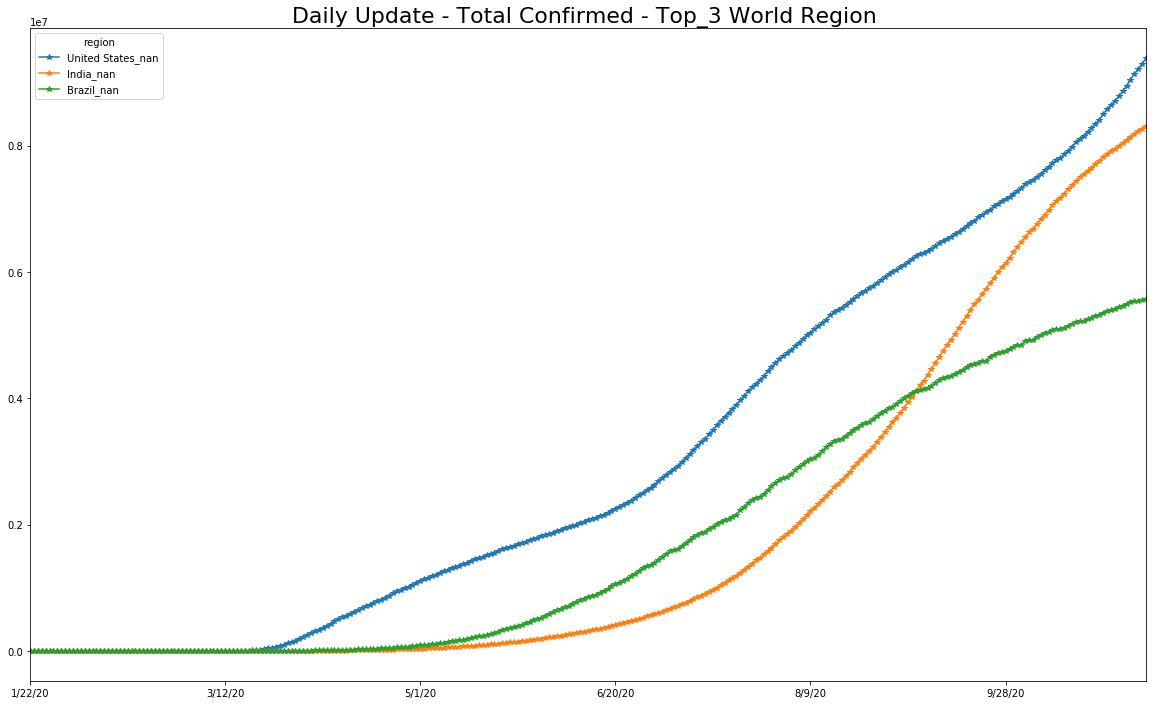

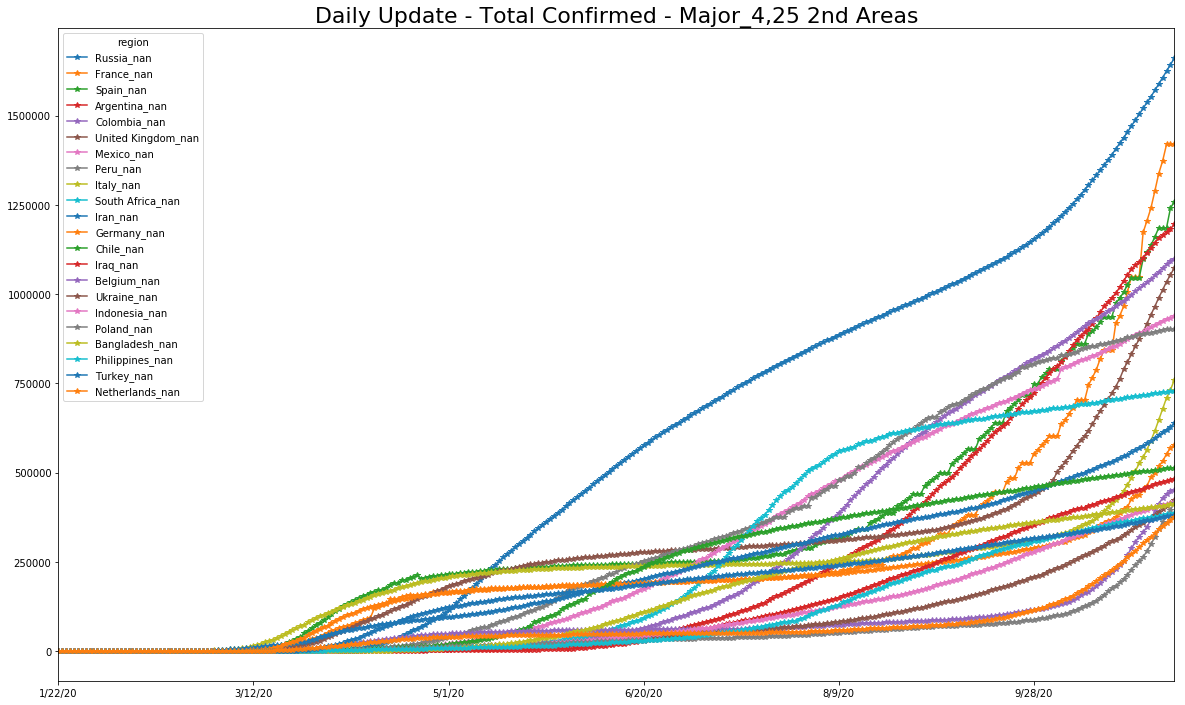

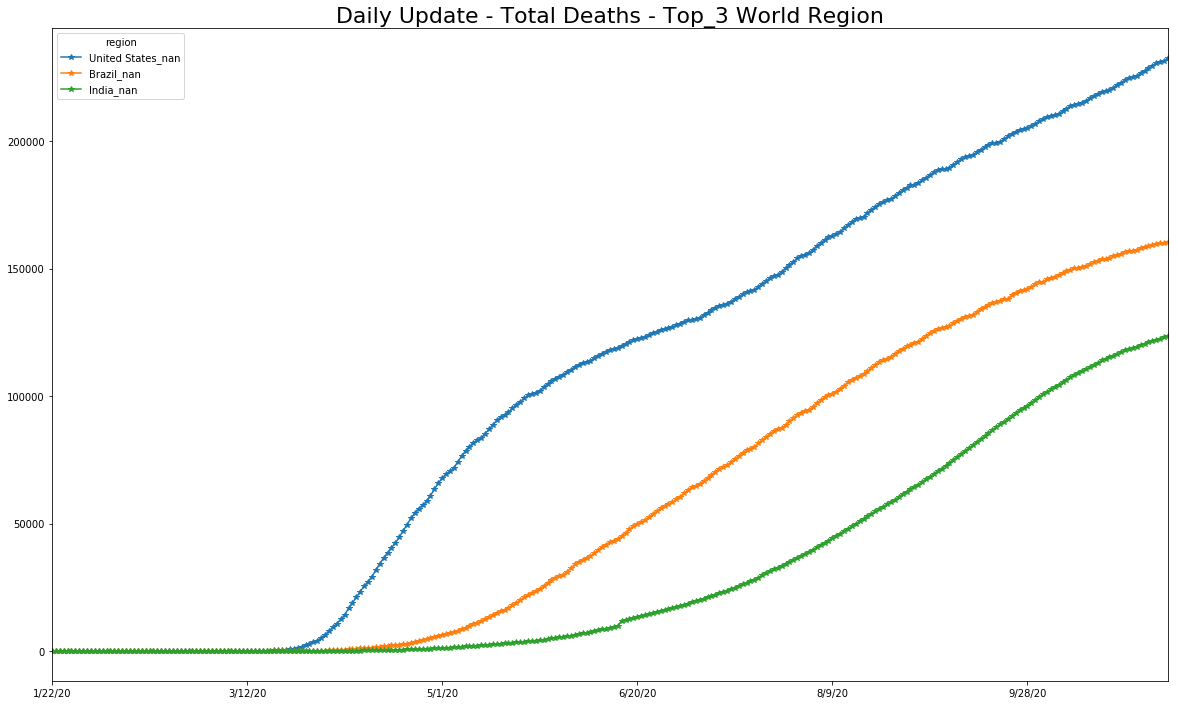

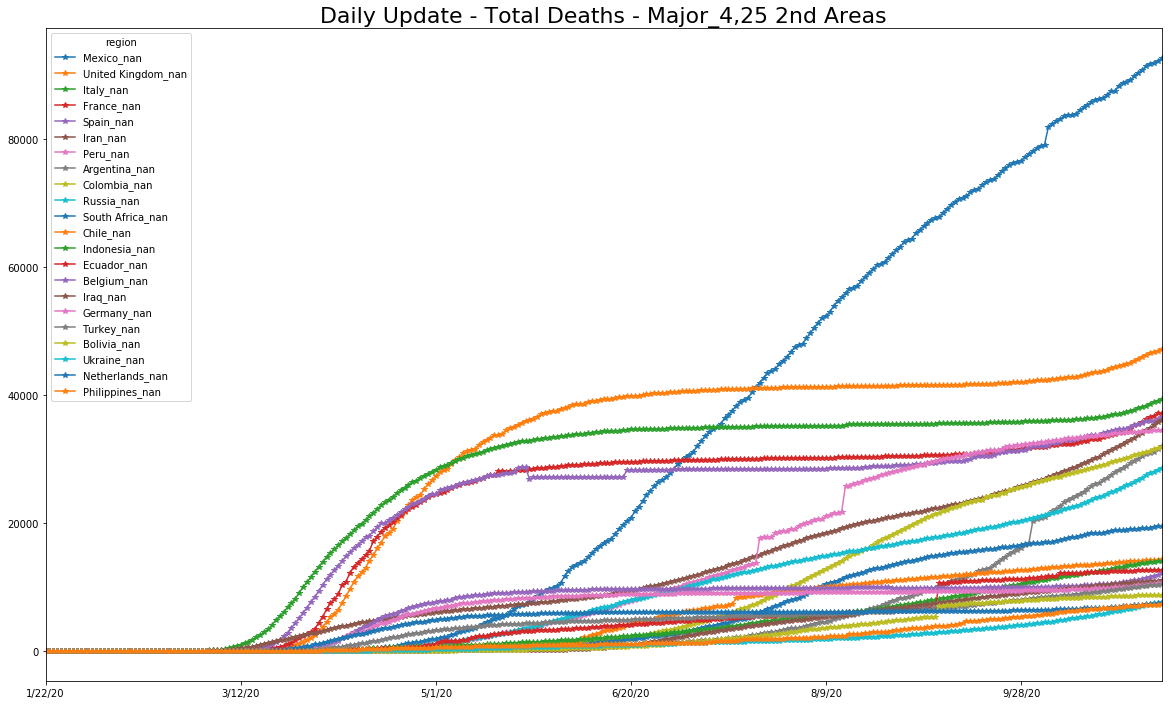

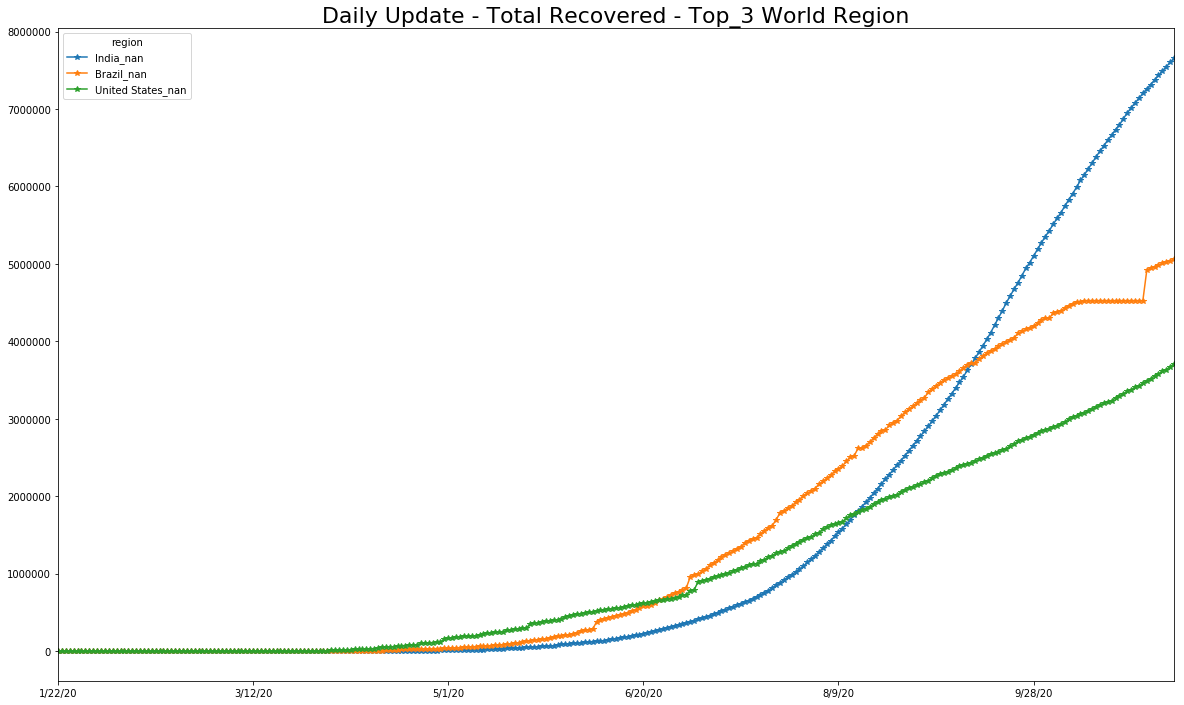

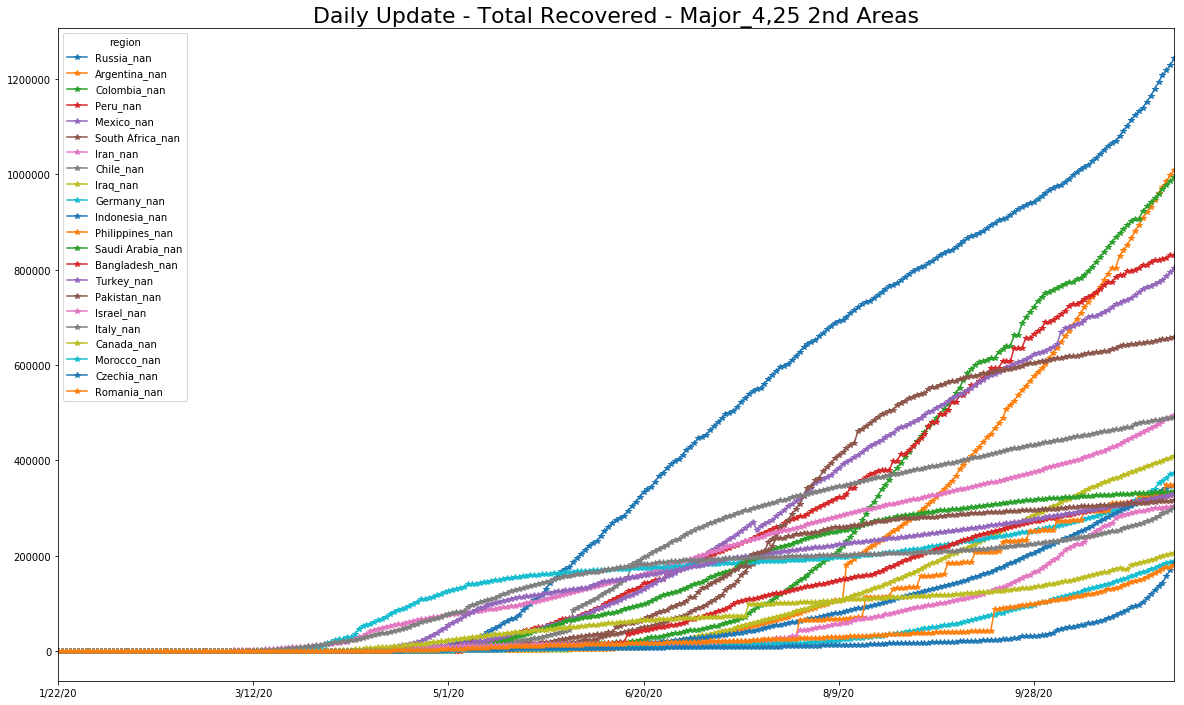

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/04


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
7/15/20  ...            3496974         1009           14581          10428   
7/16/20  ...            3574352         1026           15066          10854   
7/17/20  ...            3646373         1037           15607          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 268 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
10/31/20            41425        20875        57942         4756       10805   
11/1/20             41501        21202        58272         4825       11035   
11/2/20             41633        21523        58574         4888       11228   
11/3/20             41728        21904        58979         4910       11577   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
10/31/20                      128        1166924        89813   
11/1/20                       128        1173533        92254   
11/2/20                       128        1183131        93448   
11/3/20                       128        1195276        94776   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
10/31/20                                     114                       4425   
11/1/20                                      114                       4432   
11/2/20                                      114                       4435   
11/3/20                                      114                       4443   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
10/31/20  ...            9133404         3124           66932          92013   
11/1/20   ...            9206998         3149           67156          92325   
11/2/20   ...            9291087         3165           67254          92705   
11/3/20   ...            9382617         3196           67553          93100   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
10/31/20         1180                   53520                  10       2063   
11/1/20          1180                   54060                  10       2063   
11/2/20          1192                   54775                  10       2063   
11/3/20          1202                   55408                  10       2063   

region    Zambia_nan  Zimbabwe_nan  
10/31/20       16432          8367  
11/1/20        16480          8374  
11/2/20        16543          8389  
11/3/20        16661          8410  

[4 rows x 268 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
6936 2020-05-10  Vietnam_nan  26.9  33.0
6937 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
30819 2020-10-06     Zimbabwe_nan       7915            10            40   
30820 2020-10-07     Zimbabwe_nan       7919            17            30   
30821 2020-10-08     Zimbabwe_nan       7951             4            31   
30822 2020-10-09     Zimbabwe_nan       7994            32            53   
30823 2020-10-10     Zimbabwe_nan       8010            43            79   
30824 2020-10-11     Zimbabwe_nan       8011            16            91   
30825 2020-10-12     Zimbabwe_nan       8021             1            60   
30826 2020-10-13     Zimbabwe_nan       8036            10            27   
30827 2020-10-14     Zimbabwe_nan       8055            15            26   
30828 2020-10-15     Zimbabwe_nan       8075            19            44   
30829 2020-10-16     Zimbabwe_nan       8099            20            54   
30830 2020-10-17     Zimbabwe_nan       8110            24            63   
30831 2020-10-18     Zimbabwe_nan       8147            11            55   
30832 2020-10-19     Zimbabwe_nan       8159            37            72   
30833 2020-10-20     Zimbabwe_nan       8187            12            60   
30834 2020-10-21     Zimbabwe_nan       8215            28            77   
30835 2020-10-22     Zimbabwe_nan       8242            28            68   
30836 2020-10-23     Zimbabwe_nan       8257            27            83   
30837 2020-10-24     Zimbabwe_nan       8269            15            70   
30838 2020-10-25     Zimbabwe_nan       8276            12            54   
30839 2020-10-26     Zimbabwe_nan       8303             7  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
30848 2020-11-04  Zimbabwe_nan          0            21            43   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
30848            95         100.250447         100.514043         101.142634   

       last_day  kalman_prediction  population  infected_rate  min  max  
30848      8410             8419.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
30848 2020-11-04  Zimbabwe_nan          0            21            43   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
30848            95         100.250447         100.514043         101.142634   

       last_day  kalman_prediction  population  infected_rate  min  max  
30848      8410             8419.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
30281  2020-11-02  Zimbabwe_nan       8389             7            25   
30282  2020-11-03  Zimbabwe_nan       8410            15            27   
30283  2020-11-04  Zimbabwe_nan          0            21            43   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
30281            98         100.083782         100.299557         101.184268   
30282            86         100.179245         100.323009         101.035891   
30283            95         100.250447         100.514043         101.142634   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
30281                 8374  ...    14862924       0.000006  NaN  NaN   
30282                 8389  ...    14862924       0.000006  NaN  NaN   
30283                 8410  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
30281                                         0.000563   
30282                                         0.000564   
30283                                         0.000566   

       population_percentage : factor 9/10 infected_rate confirmed  \
30281                                           0.005635             
30282                                           0.005645             
30283                                           0.005659             

       delta : new_cases  delta : new_cases per 1M hab  \
30281               19.0                      1.278349   
30282               14.0                      0.941941   
30283                9.0                      0.605534   

       delta : roling 7day AVG  \
30281                14.000000   
30282                12.285714   
30283                13.571429   

       delta : aprox 14-day case notification rate per 100k hab  
30281                                           1.318718         
30282                                           1.157242         
30283                                           1.278349         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse           rmse           mae
258  United States_nan  8.022685e+11  895694.450448  99441.678571


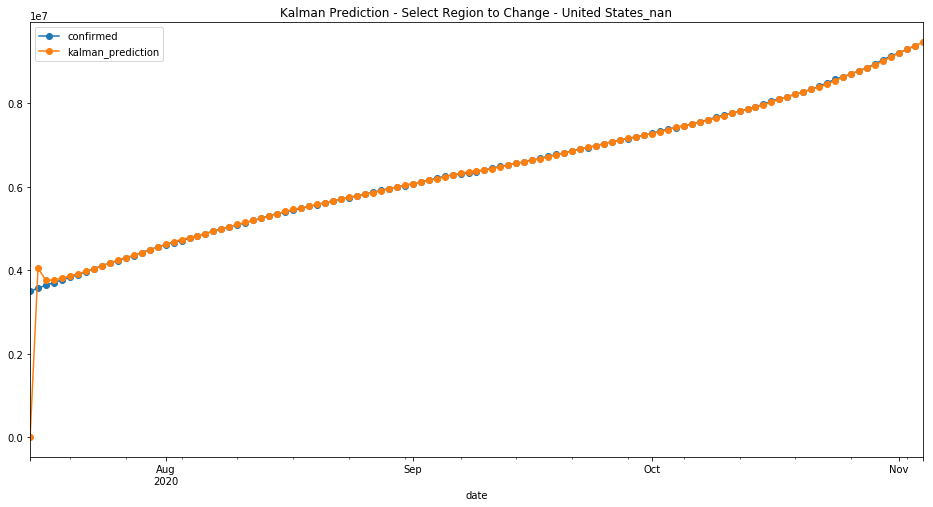

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
209  Russia_nan  2.526776e+10  158958.370809  17373.410714


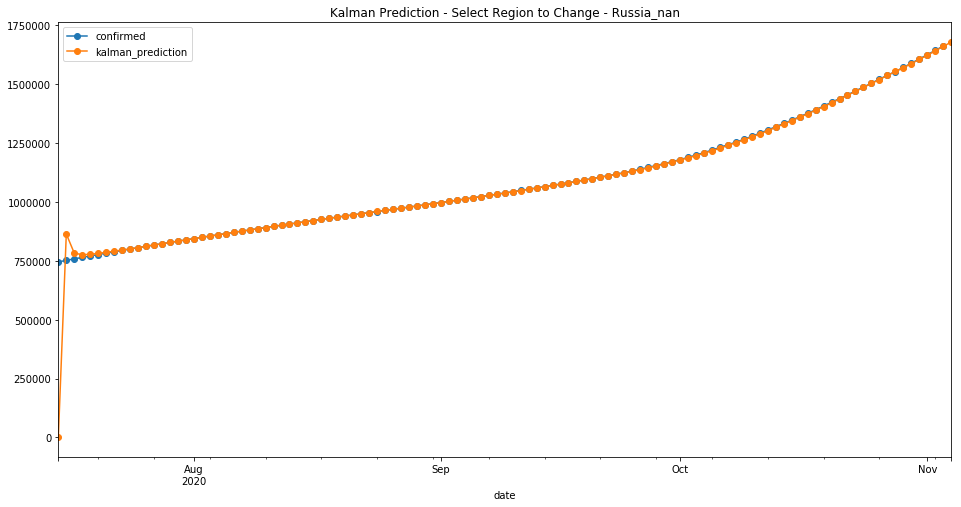

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.801365e+11  529279.195849  67982.580357


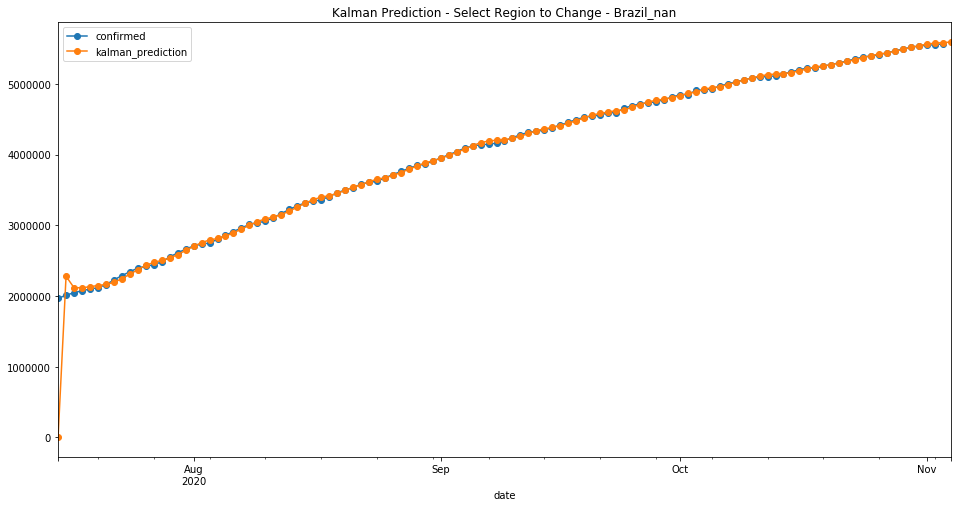

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
257  United Kingdom_nan  1.080083e+10  103927.019105  12019.160714


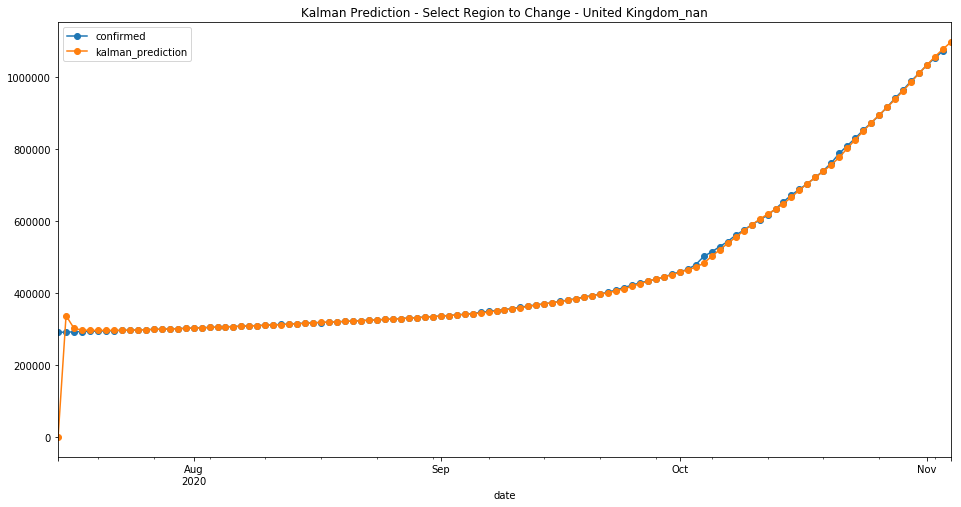

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoxmbruvb
  JVM stdout: /tmp/tmpoxmbruvb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoxmbruvb/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 6 days
H2O_cluster_name:           H2O_from_python_unknownUser_635j9p
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-10-08
last_train_date= 2020-11-03
first_bootstrap_date= 2020-10-26
boost_bootstrap_date= 2020-10-31
first_test_date= 2020-10-25
last_test_date= 2020-11-04
first_valid_date= 2020-11-02


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   41076.0      40937 2020-10-26  Afghanistan_nan
1   41161.0      41032 2020-10-27  Afghanistan_nan
2   41255.0      41145 2020-10-28  Afghanistan_nan
3   41357.0      41268 2020-10-29  Afghanistan_nan
4   41476.0      41334 2020-10-30  Afghanistan_nan
5   41574.0      41425 2020-10-31  Afghanistan_nan
6   41661.0      41501 2020-11-01  Afghanistan_nan
7   41743.0      41633 2020-11-02  Afghanistan_nan
8   41847.0      41728 2020-11-03  Afghanistan_nan
9   41953.0          0 2020-11-04  Afghanistan_nan
10  19455.0      19445 2020-10-26      Albania_nan
11  19758.0      19729 2020-10-27      Albania_nan
12  20046.0      20040 2020-10-28      Albania_nan
13  20333.0      20315 2020-10-29      Albania_nan
14  20636.0      20634 2020-10-30      Albania_nan
15  20917.0      20875 2020-10-31      Albania_nan
16  21221.0      21202 2020-11-01      Albania_nan
17  21478.0      21523 2020-11-02      Albania_nan
18  21798.0      21904 2020-11-03      Albania_nan
19  22136.0          0 2020-11-04      Albania_nan
20  56490.0      56419 2020-10-26      Algeria_nan
21  56771.0      56706 2020-10-27      Algeria_nan
22  57062.0      57026 2020-10-28      Algeria_nan
23  57377.0      57332 2020-10-29      Algeria_nan
24  57696.0      57651 2020-10-30      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  54884.0      55269 2020-10-31  Azerbaijan_nan
176  56013.0      56444 2020-11-01  Azerbaijan_nan
177  57228.0      57040 2020-11-02  Azerbaijan_nan
178  58113.0      58282 2020-11-03  Azerbaijan_nan
179  59211.0          0 2020-11-04  Azerbaijan_nan
180   6429.0       6410 2020-10-26     Bahamas_nan
181   6777.0       6502 2020-10-27     Bahamas_nan
182   6624.0       6549 2020-10-28     Bahamas_nan
183   6759.0       6607 2020-10-29     Bahamas_nan
184   6783.0       6644 2020-10-30     Bahamas_nan
185   6853.0       6714 2020-10-31     Bahamas_nan
186   6840.0       6714 2020-11-01     Bahamas_nan
187   6995.0       6735 2020-11-02     Bahamas_nan
188   6961.0       6790 2020-11-03     Bahamas_nan
189   6916.0          0 2020-11-04     Bahamas_nan
190  80431.0      80533 2020-10-26     Bahrain_nan
191  80727.0      80765 2020-10-27     Bahrain_nan
192  80971.0      81022 2020-10-28     Bahrain_nan
193  81207.0      81262 2020-10-29     Bahrain_nan
194  81427.0      81466 2020-10-30     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220   93518.0      93707 2020-10-26  Belarus_nan
221   94431.0      94609 2020-10-27  Belarus_nan
222   95370.0      95545 2020-10-28  Belarus_nan
223   96341.0      96529 2020-10-29  Belarus_nan
224   97354.0      97499 2020-10-30  Belarus_nan
225   98367.0      98482 2020-10-31  Belarus_nan
226   99389.0      99459 2020-11-01  Belarus_nan
227  100403.0     100400 2020-11-02  Belarus_nan
228  101381.0     101329 2020-11-03  Belarus_nan
229  102332.0          0 2020-11-04  Belarus_nan
230  333903.0     333718 2020-10-26  Belgium_nan
231  348891.0     347289 2020-10-27  Belgium_nan
232  363624.0     368337 2020-10-28  Belgium_nan
233  383853.0     392258 2020-10-29  Belgium_nan
234  406940.0     412314 2020-10-30  Belgium_nan
235  428125.0     429229 2020-10-31  Belgium_nan
236  447297.0     441018 2020-11-01  Belgium_nan
237  461282.0     447355 2020-11-02  Belgium_nan
238  468876.0     452541 2020-11-03  Belgium_nan
239  473335.0          0 2020-11-04  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [max, min]
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2250352870.159166
# MSE on the validation data =  1713578044202.9207
# R^2 on the training data =  0.9990468904215271
# R^2 on the validation data =  0.4568997072636024


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1604502393417_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           14199499.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       20.0       23.0       22.82      1717.0      2351.0     2220.856



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2250352870.159166
RMSE: 47437.88433477157
MAE: 4589.6032262644685
RMSLE: 0.29942775232891694
Mean Residual Deviance: 2250352870.159166

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 1713578044202.9207
RMSE: 1309037.0675435134
MAE: 327254.4580759951
RMSLE: 6.982676005166175
Mean Residual Deviance: 1713578044202.9207

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-04 15:06:41   0.081 sec              0.0            NaN   
1     2020-11-04 15:06:42   0.545 sec              1.0  109556.736855   
2     2020-11-04 15:06:42   0.722 sec              2.0  107224.599614   
3     2020-11-04 15:06:42   0.883 sec              3.0  112898.949550   
4     2020-11-04 15:06:42   1.110 sec              4.0  100003.219364   
5     2020-11-04 15:06:42   1.411 sec              5.0   97545.101190   
6     2020-11-04 15:06:43   1.643 sec              6.0   90070.059976   
7     2020-11-04 15:06:43   1.739 sec              7.0   87098.679543   
8     2020-11-04 15:06:43   1.825 sec              8.0   85781.202886   
9     2020-11-04 15:06:43   1.916 sec              9.0   80757.372846   
10    2020-11-04 15:06:43   1.999 sec             10.0   73381.169241   
11    2020-11-04 15:06:43   2.072 sec             11.0   71756.615262   
12    2020-11-04 15:06:43   2.126 sec             12.0   67425.603430   
13    2020-11-04 15:06:43   2.177 sec             13.0   66529.012270   
14    2020-11-04 15:06:43   2.254 sec             14.0   63975.230394   
15    2020-11-04 15:06:43   2.316 sec             15.0   62257.769447   
16    2020-11-04 15:06:43   2.381 sec             16.0   62291.656520   
17    2020-11-04 15:06:43   2.453 sec             17.0   61745.854593   
18    2020-11-04 15:06:43   2.498 sec             18.0   58964.933658   
19    2020-11-04 15:06:44   2.549 sec             19.0   58962.705114   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   14836.840146       1.200268e+10     1.373954e+06   360482.908990   
2   13399.256092       1.149711e+10     1.339722e+06   345194.735330   
3   15149.269080       1.274617e+10     1.338654e+06   342412.418937   
4   13429.036528       1.000064e+10     1.327502e+06   335276.966340   
5   12956.828564       9.515047e+09     1.324936e+06   333747.231583   
6   12248.162675       8.112616e+09     1.325441e+06   332051.646627   
7   11437.600823       7.586180e+09     1.326117e+06   330854.758277   
8   10864.732406       7.358415e+09     1.324444e+06   330781.654703   
9   10586.004350       6.521753e+09     1.325270e+06   330358.048960   
10  10160.335884       5.384796e+09     1.317239e+06   329956.262761   
11   9822.987601       5.149012e+09     1.318375e+06   329907.607631   
12   9523.019793       4.546212e+09     1.317367e+06   330746.838715   
13   9351.108692       4.426109e+09     1.318103e+06   330372.555528   
14   9054.581100       4.092830e+09     1.319767e+06   330212.743721   
15   8617.460237       3.876030e+09     1.319476e+06   329448.971734   
16   8426.302232       3.880250e+09     1.320434e+06   329215.397232   
17   8167.935203       3.812551e+09     1.320565e+06   328644.095185   
18   7712.950345       3.476863e+09     1.320953e+06   328561.161102   
19   7675.971234       3.476601e+09     1.321100e+06   328345.947281   

    validation_deviance  
0                   NaN  
1          1.887748e+12  
2          1.794854e+12  
3          1.791995e+12  
4          1.762261e+12  
5          1.755456e+12  
6          1.756793e+12  
7          1.758586e+12  
8          1.754152e+12  
9          1.756342e+12  
10         1.735119e+12  
11         1.738113e+12  
12         1.735455e+12  
13         1.737396e+12  
14         1.741784e+12  
15         1.741018e+12  
16         1.743546e+12  
17         1.743892e+12  
18         1.744918e+12  
19         1.745305e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.635441e+18           1.000000    0.324491
1           last_day         1.302686e+18           0.796535    0.258469
2             region         9.146198e+17           0.559250    0.181472
3       7_day_change         4.229808e+17           0.258634    0.083925
4       3_day_change         3.607815e+17           0.220602    0.071583
5       1_day_change         2.401868e+17           0.146864    0.047656
6      infected_rate         5.635721e+16           0.034460    0.011182
7  3_day_change_rate         3.803520e+16           0.023257    0.007547
8  7_day_change_rate         3.484541e+16           0.021306    0.006914
9  1_day_change_rate         3.407752e+16           0.020837    0.006761

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.635441e+18           1.000000    0.324491
1           last_day         1.302686e+18           0.796535    0.258469
2             region         9.146198e+17           0.559250    0.181472
3       7_day_change         4.229808e+17           0.258634    0.083925
4       3_day_change         3.607815e+17           0.220602    0.071583
5       1_day_change         2.401868e+17           0.146864    0.047656
6      infected_rate         5.635721e+16           0.034460    0.011182
7  3_day_change_rate         3.803520e+16           0.023257    0.007547
8  7_day_change_rate         3.484541e+16           0.021306    0.006914
9  1_day_change_rate         3.407752e+16           0.020837    0.006761

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


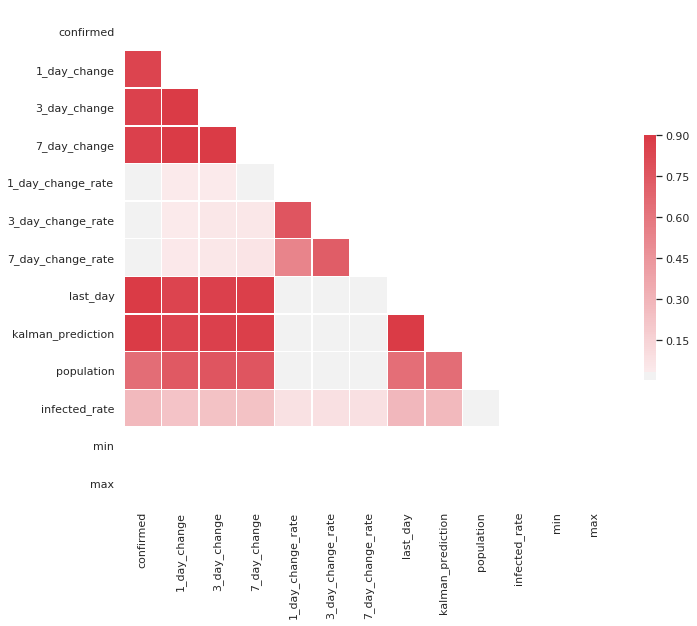

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.841490
3_day_change         0.861295
7_day_change         0.868351
1_day_change_rate    0.020778
3_day_change_rate    0.022874
7_day_change_rate    0.024753
last_day             0.987832
kalman_prediction    0.988841
population           0.645816
infected_rate        0.276682
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


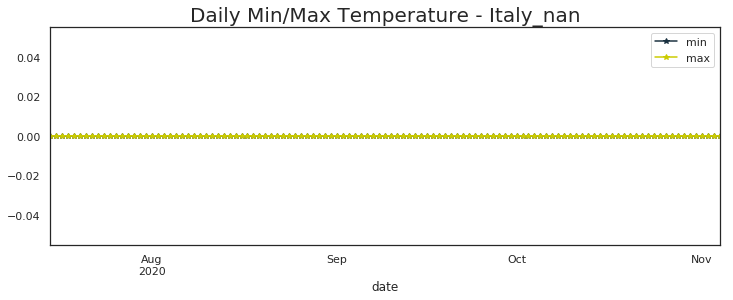

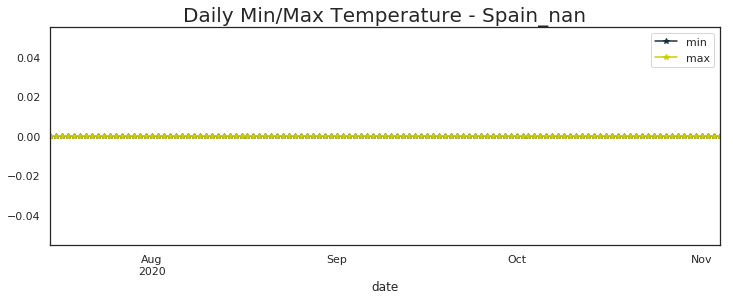

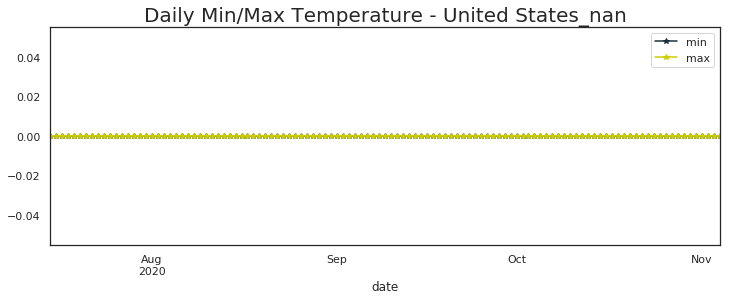

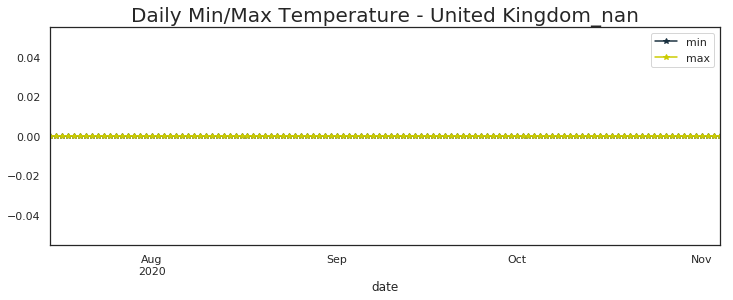

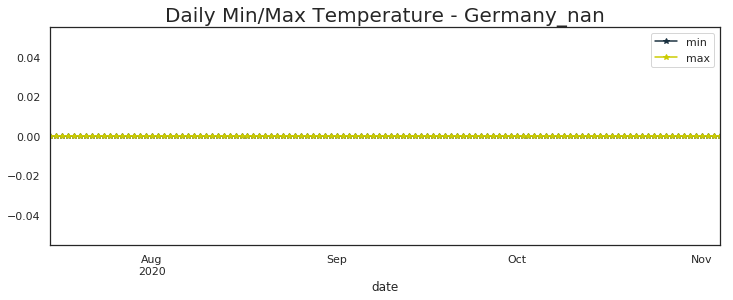

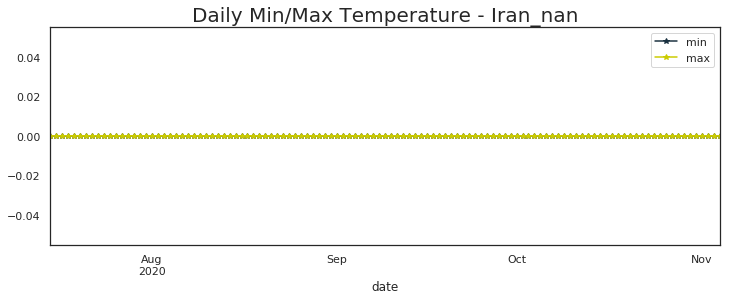

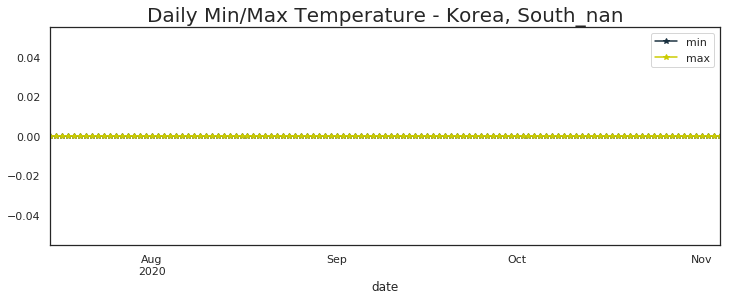

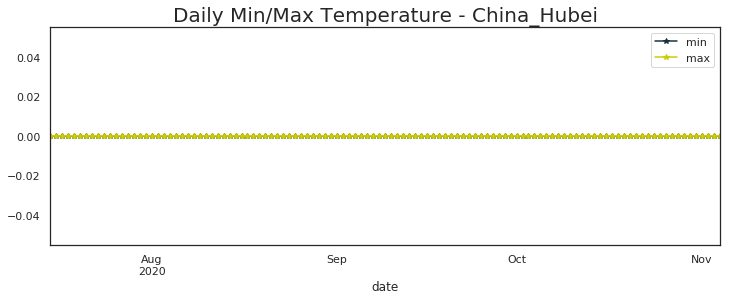

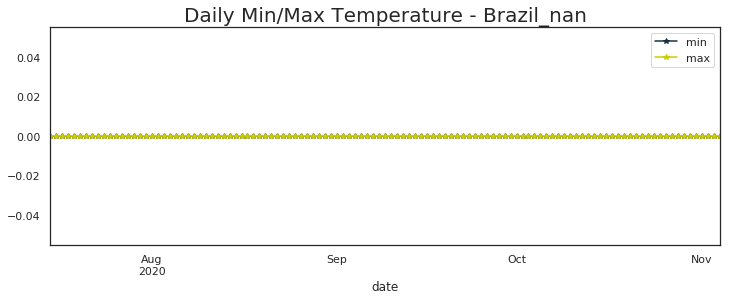

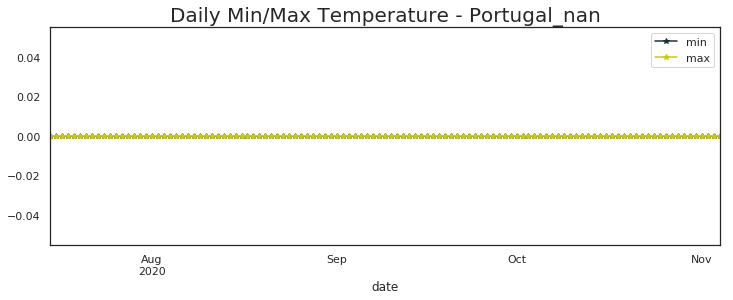

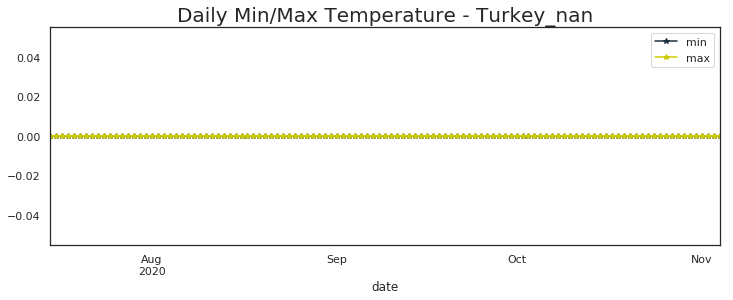

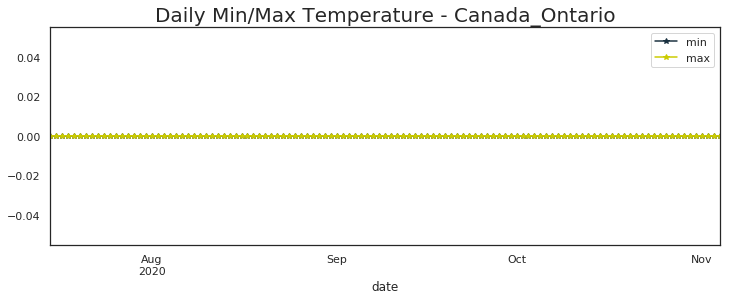

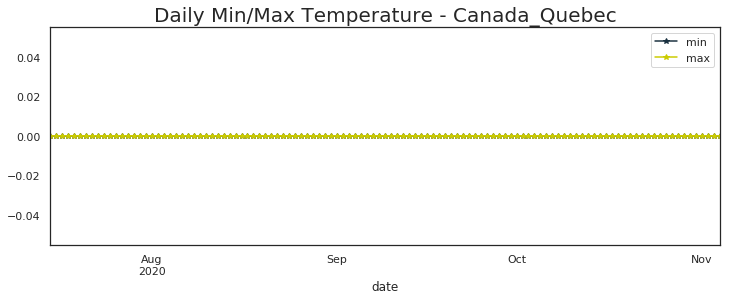

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
Russia_nan                  0.0  0.0
France_nan                  0.0  0.0
Spain_nan                   0.0  0.0
Argentina_nan               0.0  0.0
Colombia_nan                0.0  0.0
United Kingdom_nan          0.0  0.0
Mexico_nan                  0.0  0.0
Peru_nan                    0.0  0.0
Italy_nan                   0.0  0.0
South Africa_nan            0.0  0.0
Iran_nan                    0.0  0.0
Germany_nan                 0.0  0.0
Chile_nan                   0.0  0.0
Iraq_nan                    0.0  0.0
Belgium_nan                 0.0  0.0
Ukraine_nan                 0.0  0.0
Indonesia_nan               0.0  0.0
Poland_nan                  0.0  0.0
Bangladesh_nan              0.0  0.0
Philippines_nan             0.0  0.0
Turkey_nan                  0.0  0.0
Ne

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

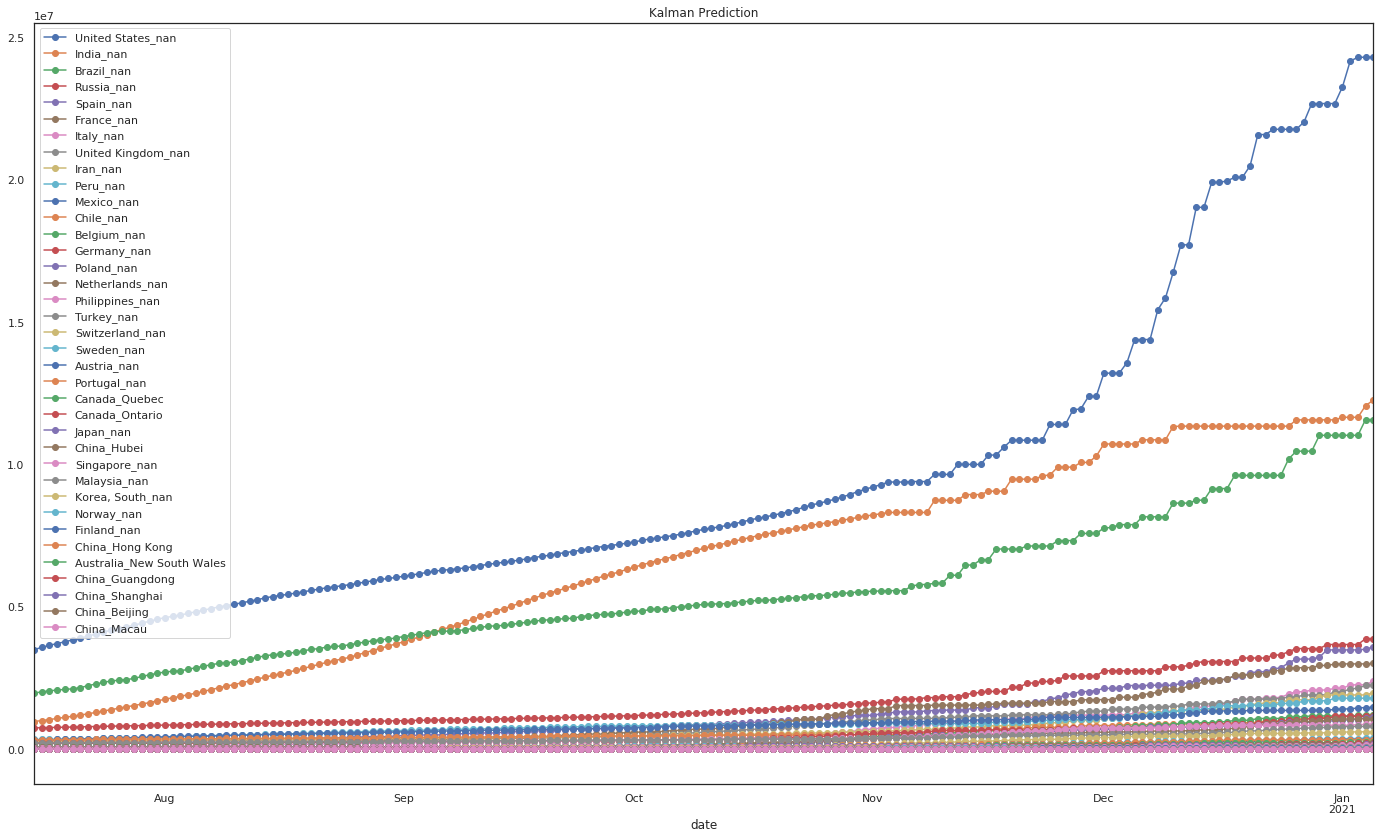

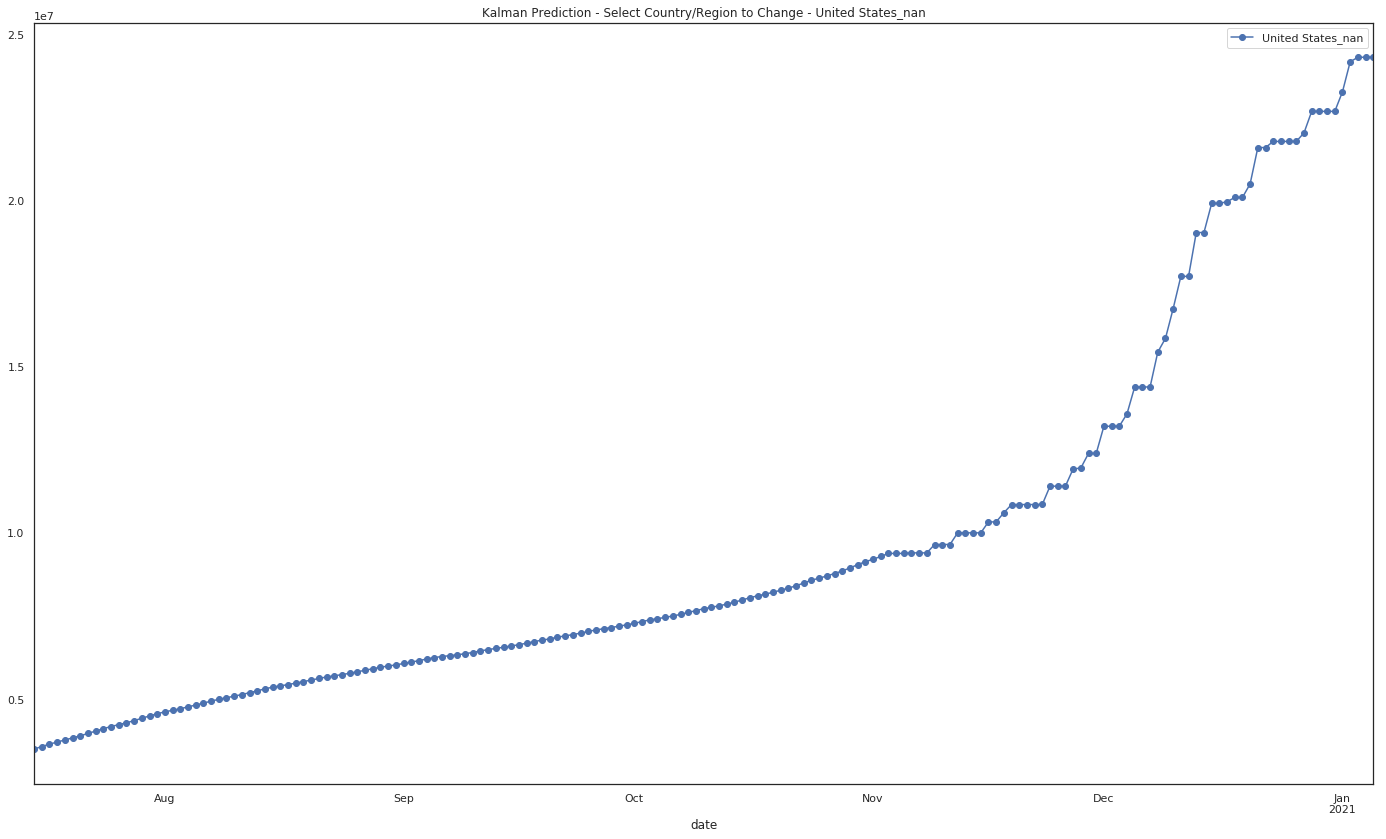

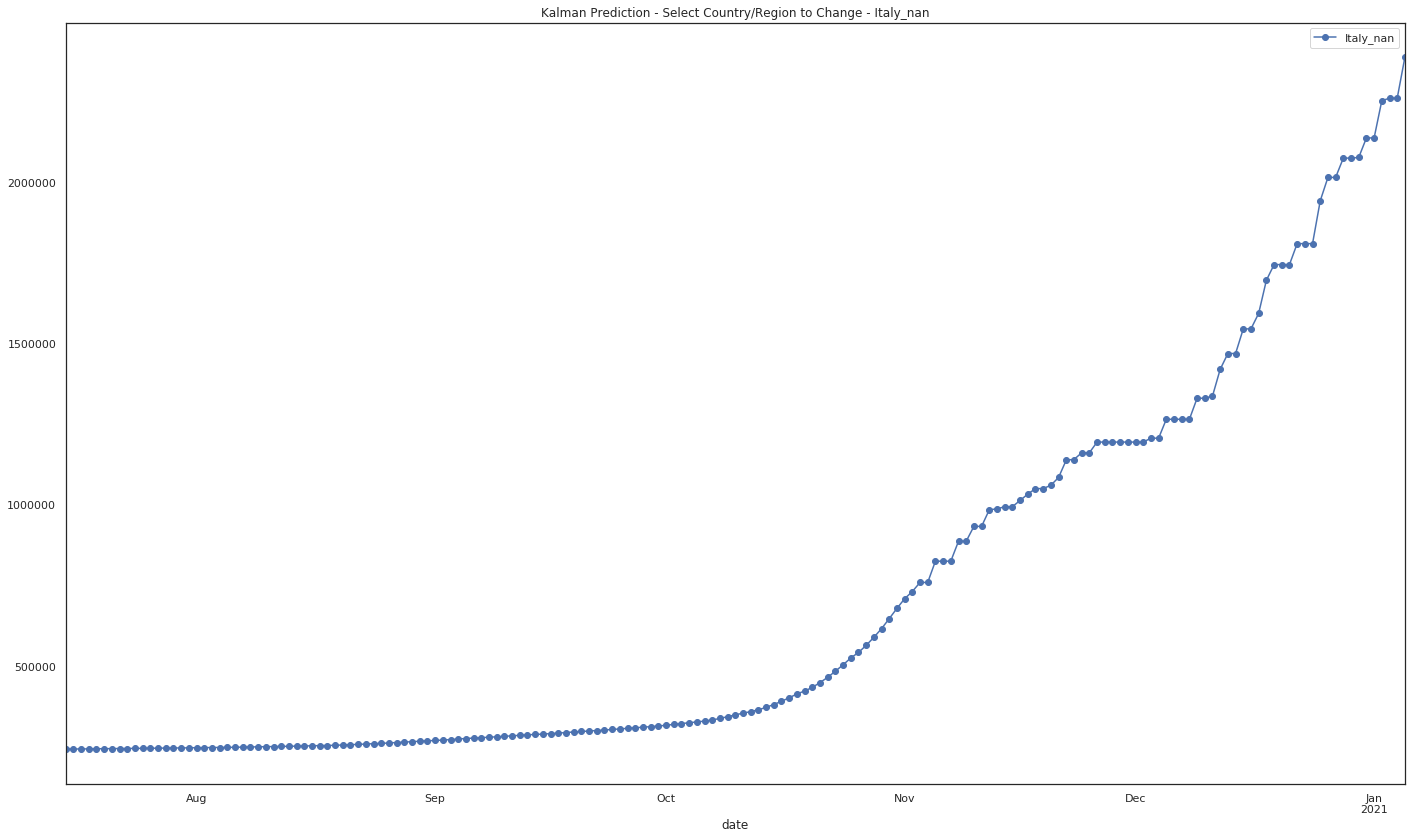

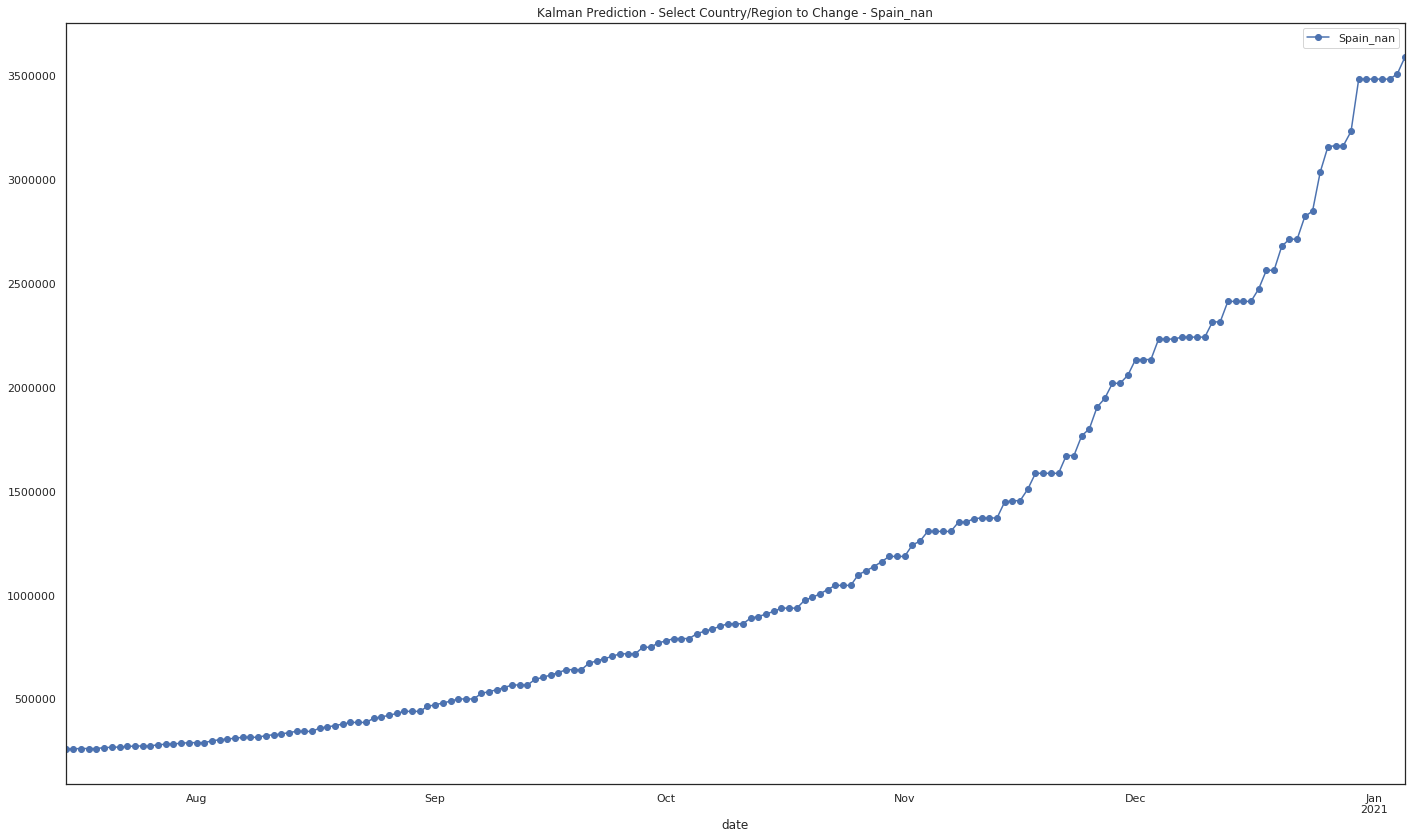

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


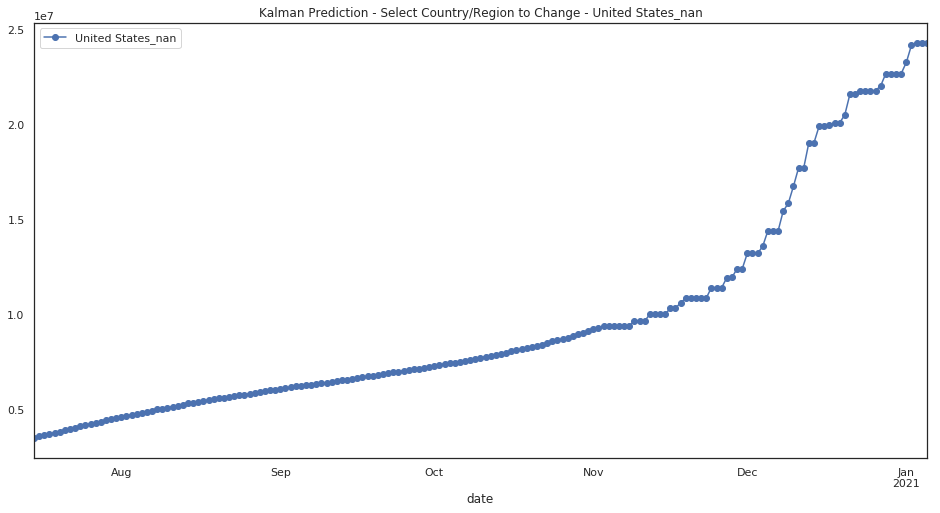

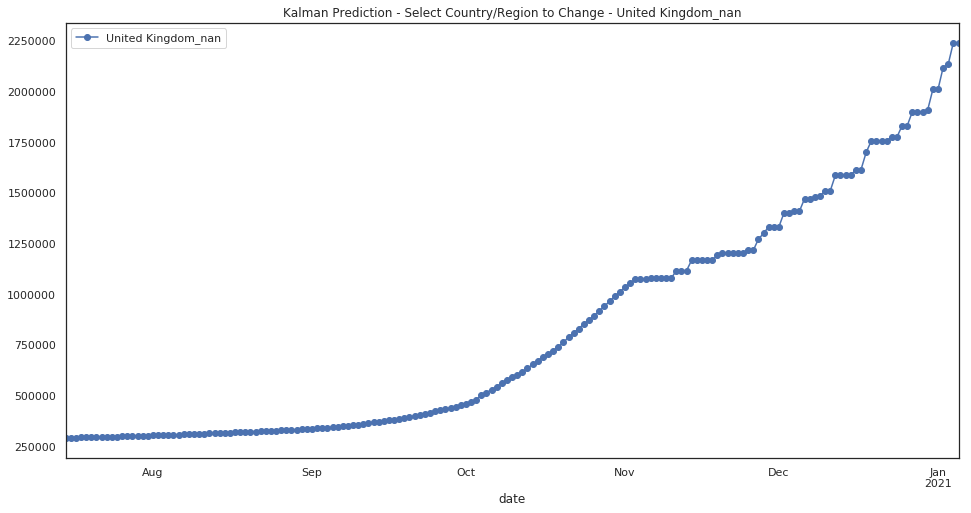

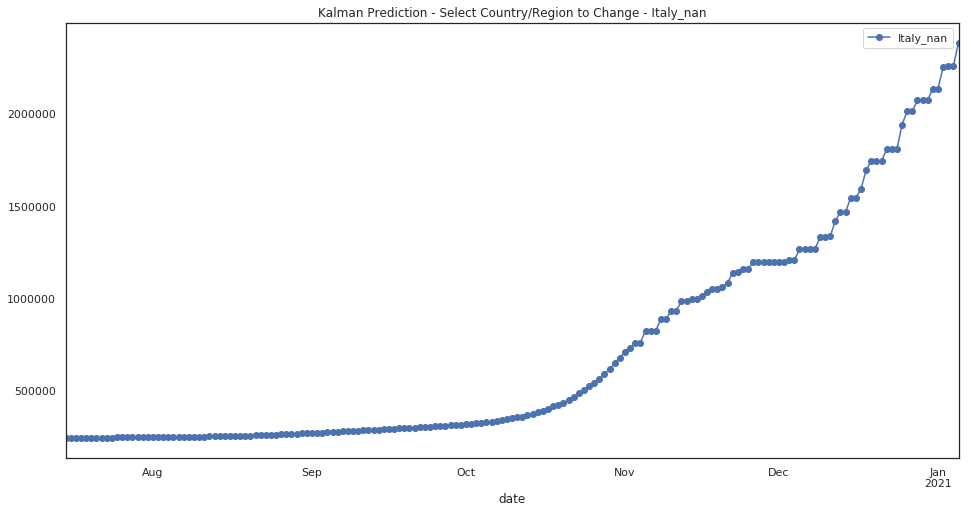

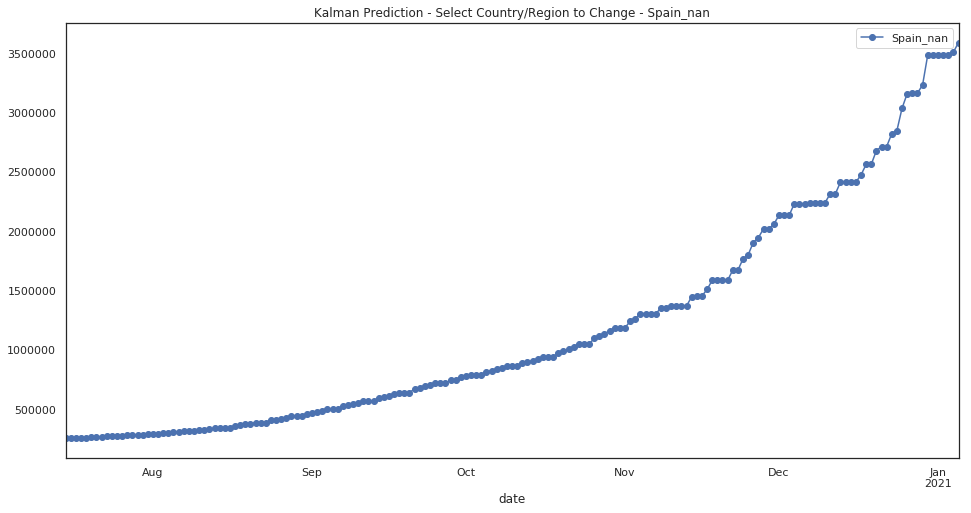

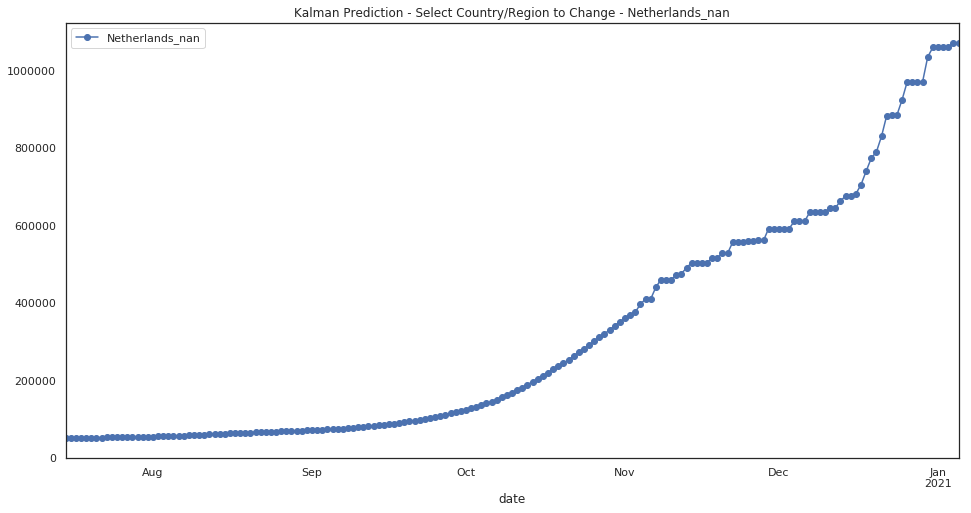

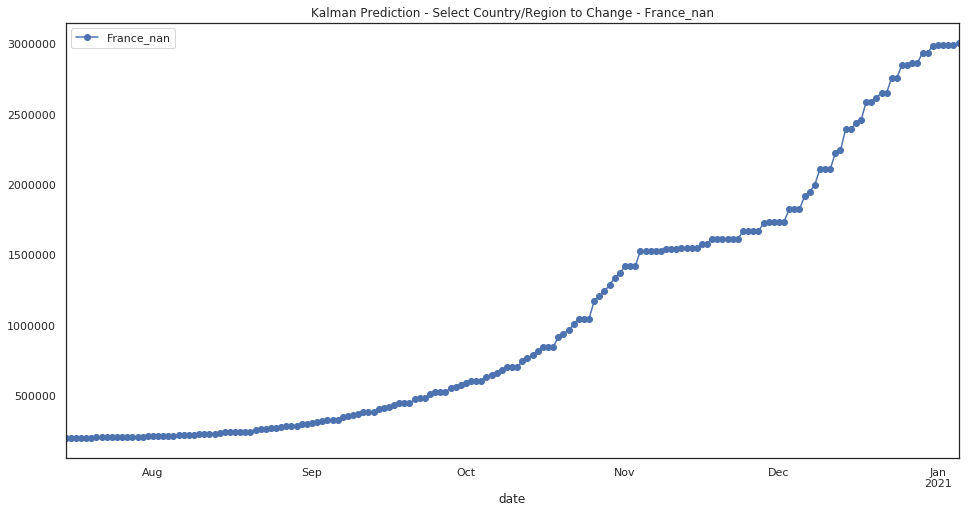

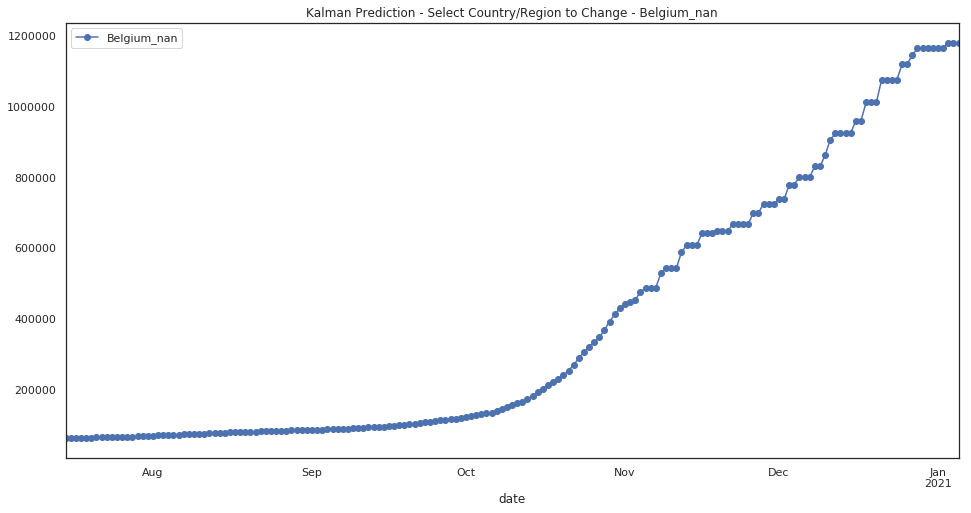

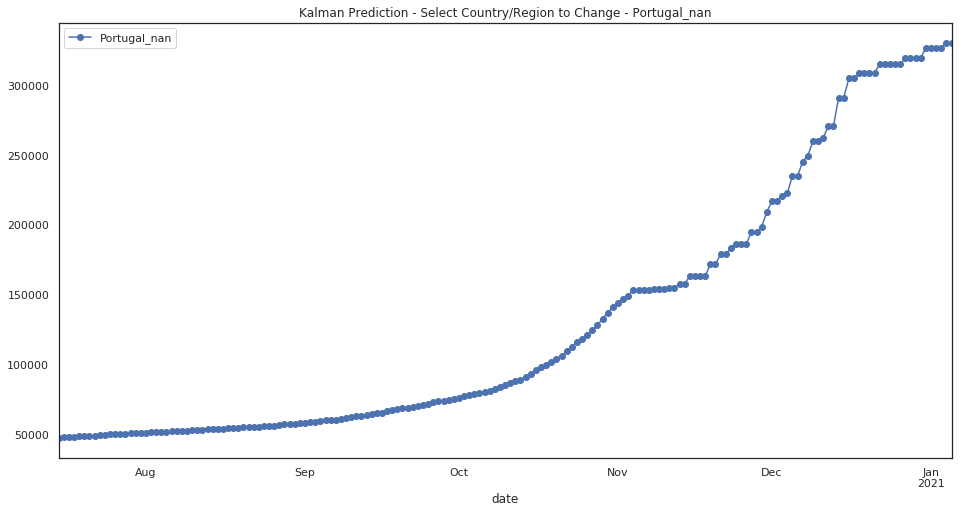

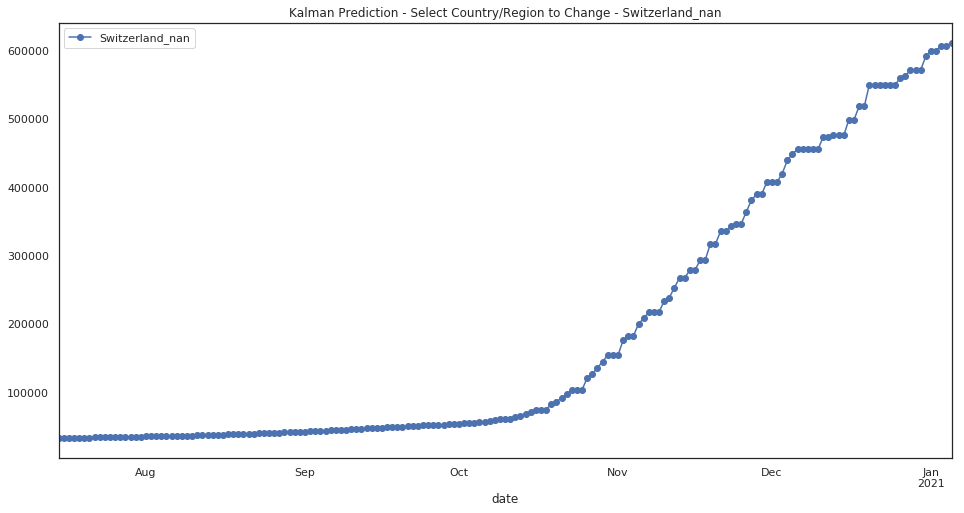

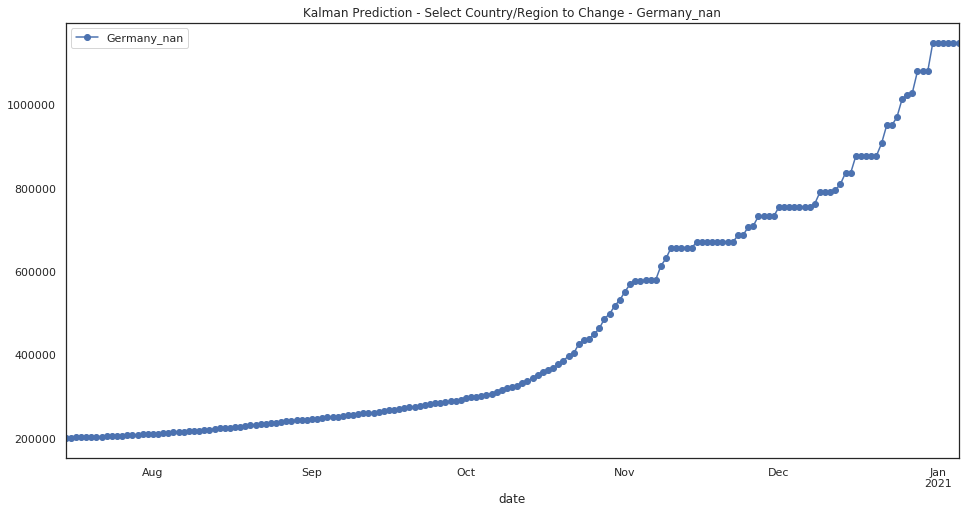

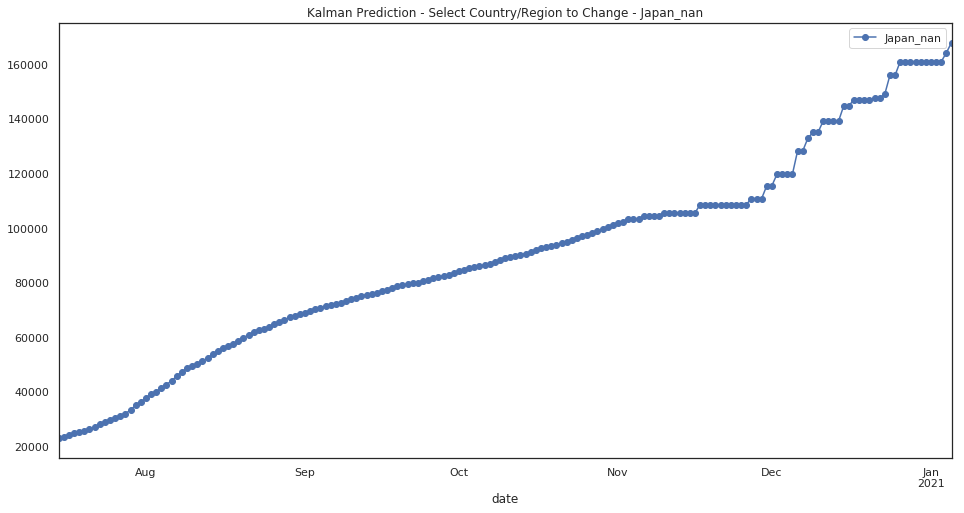

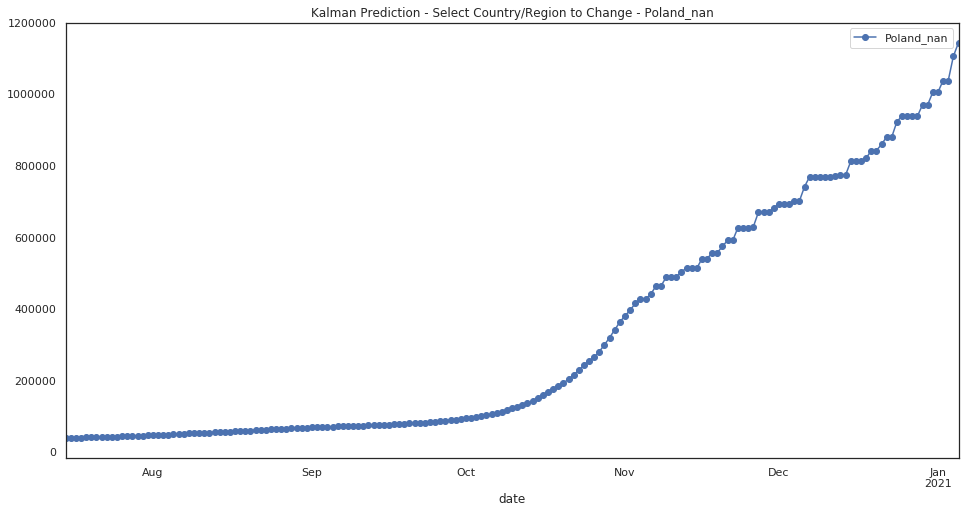

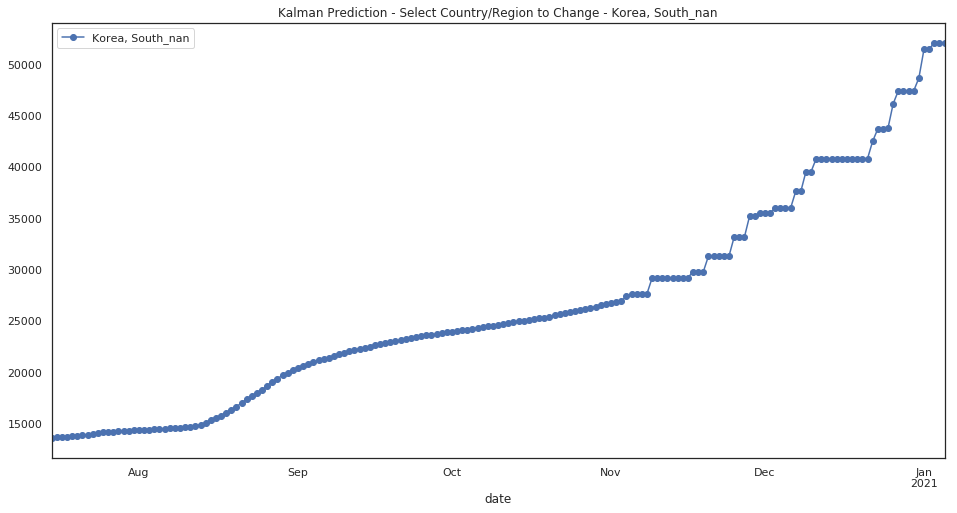

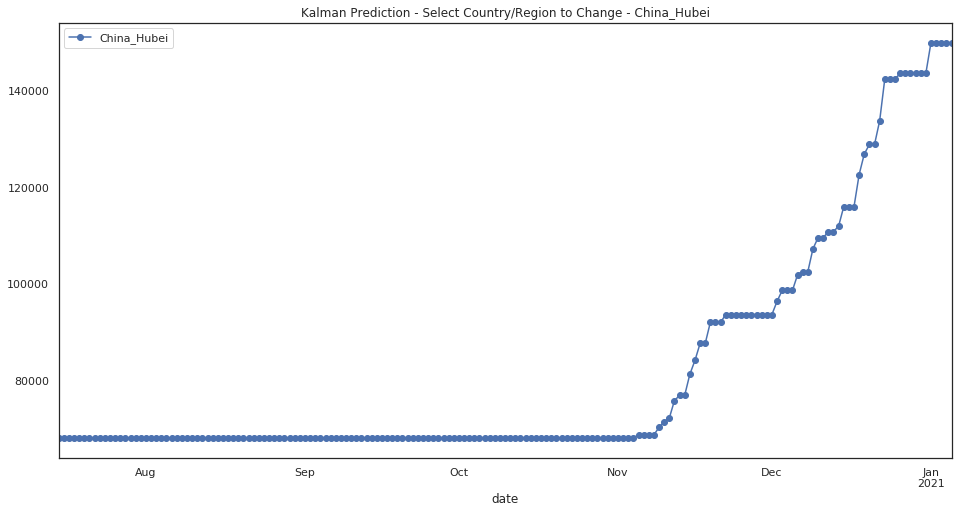

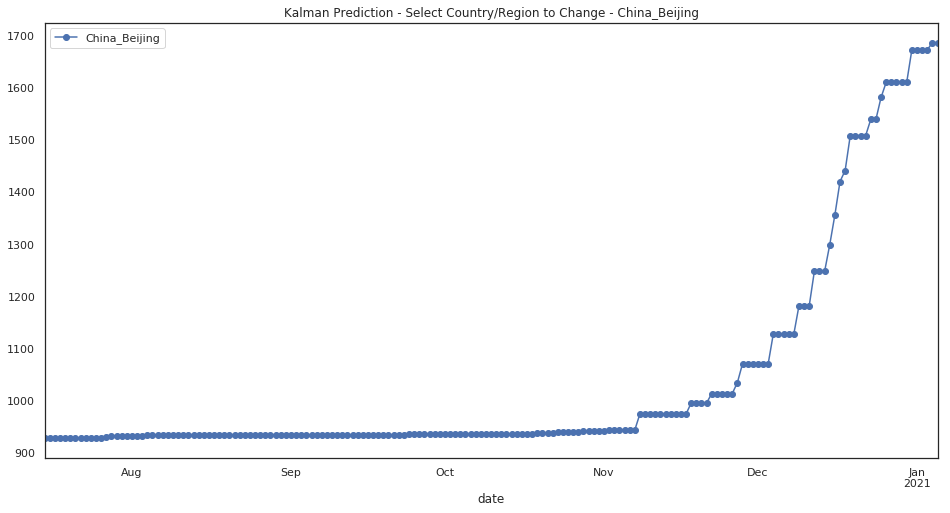

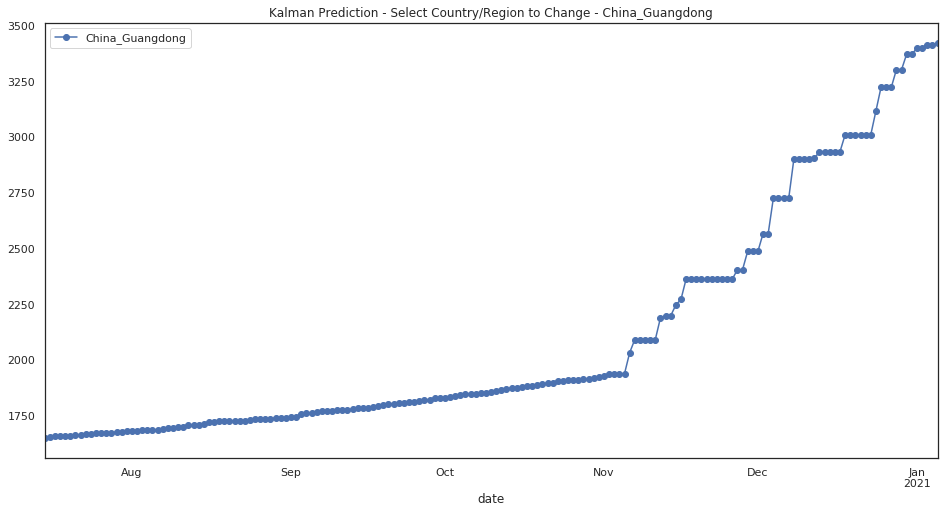

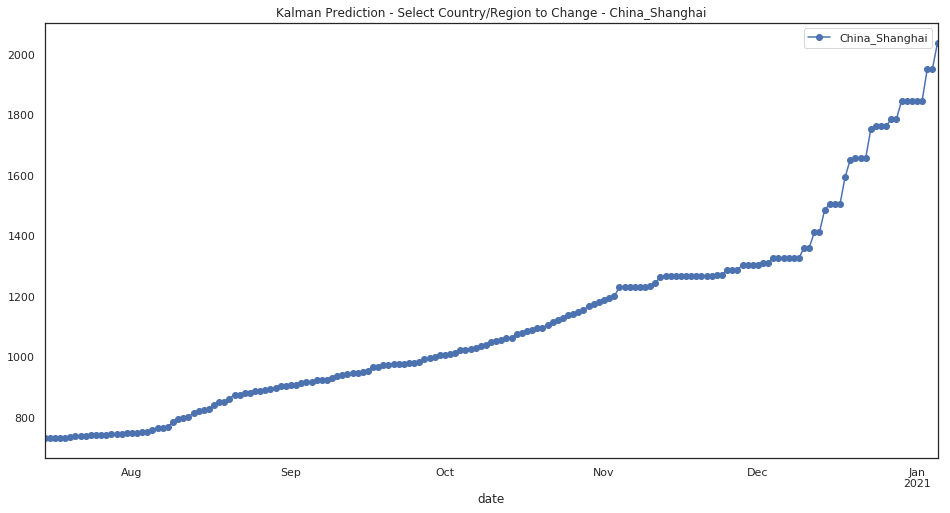

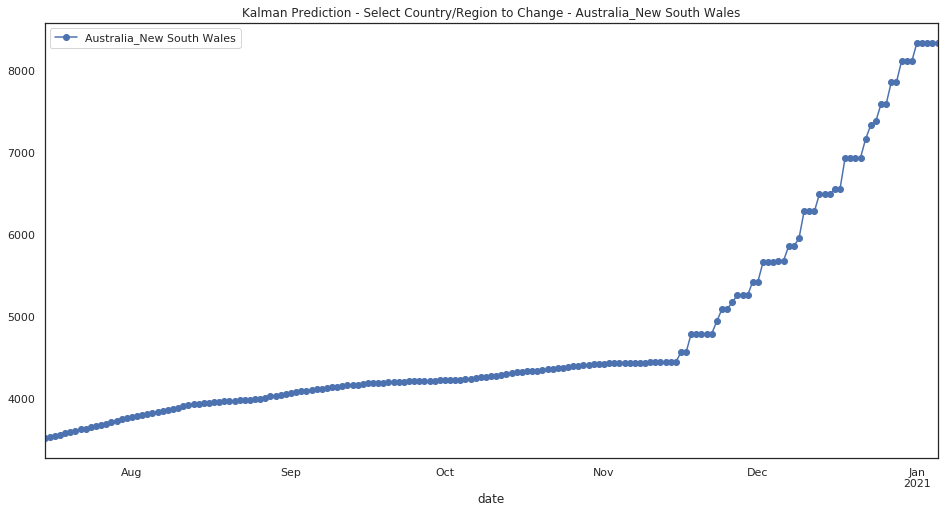

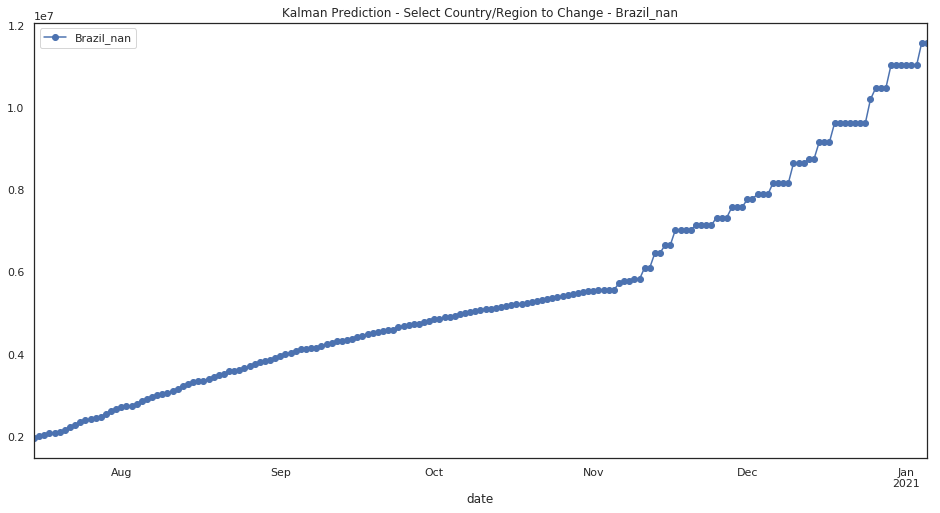

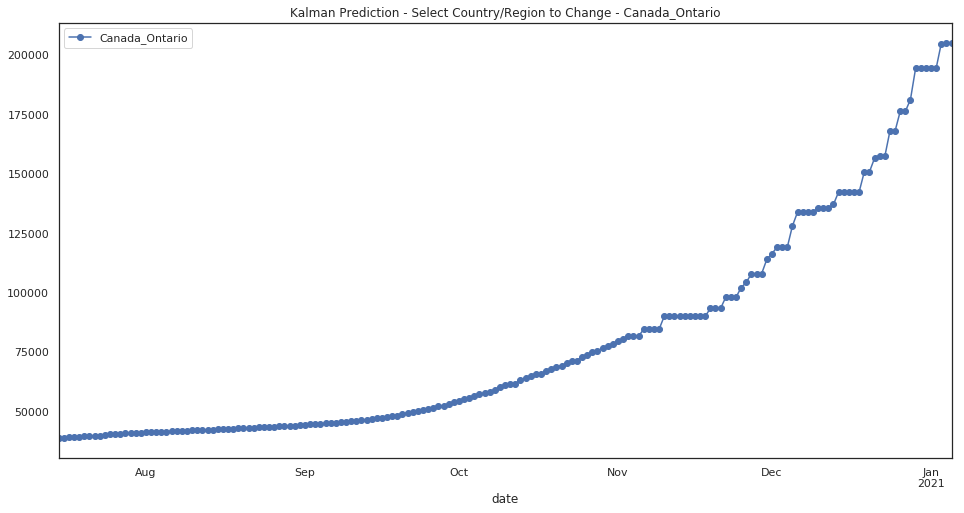

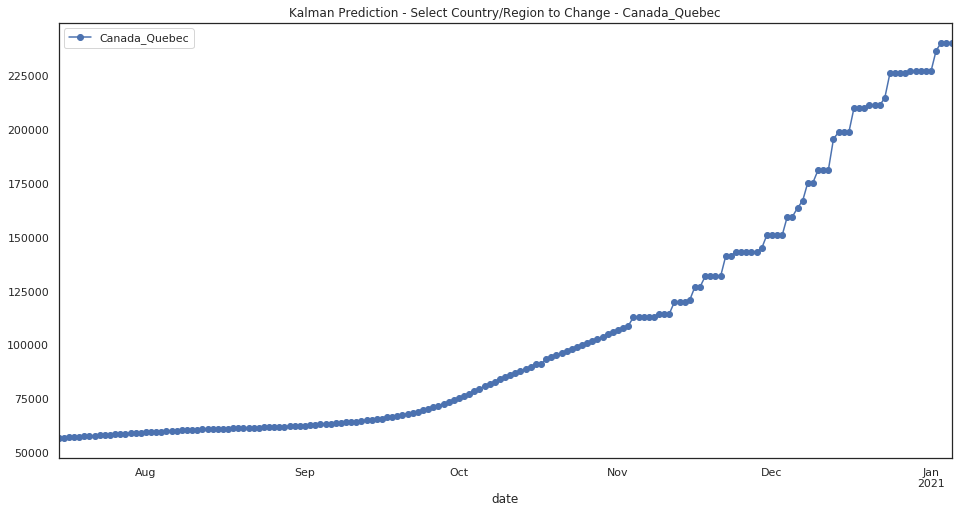

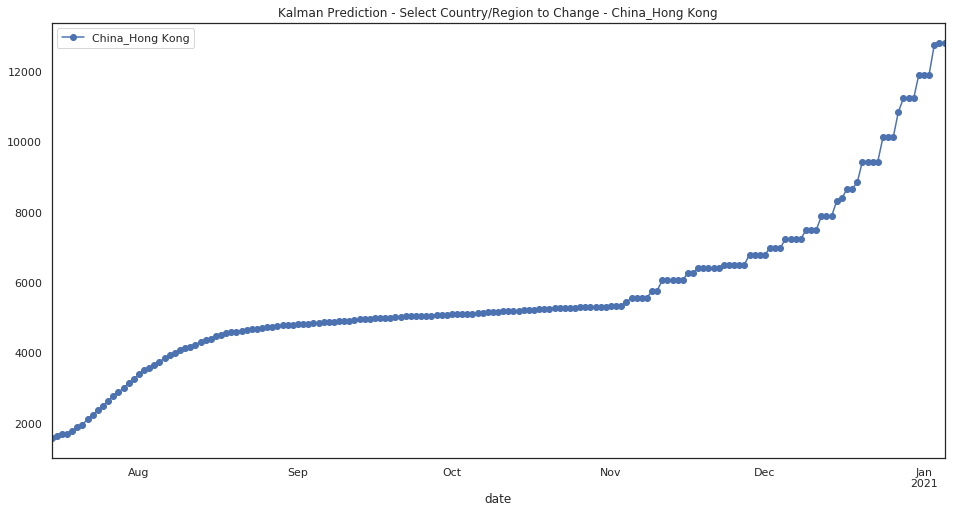

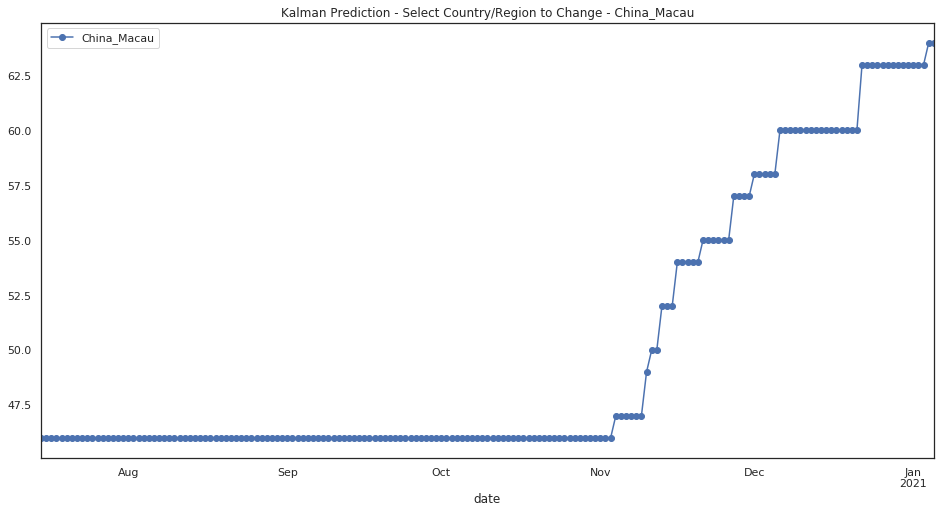

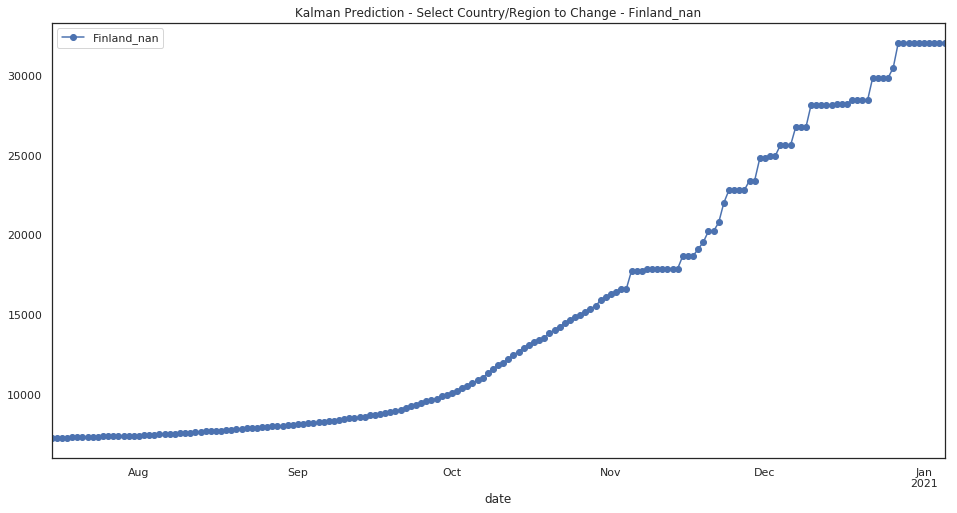

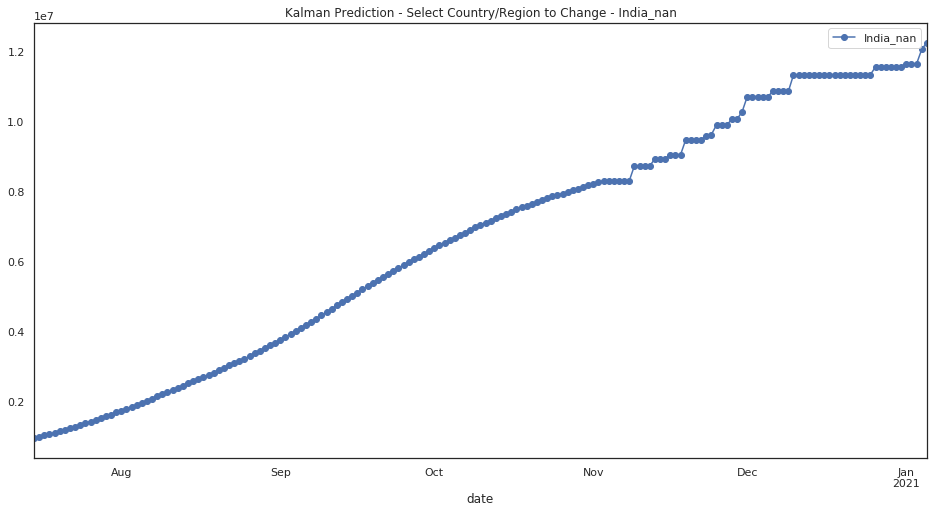

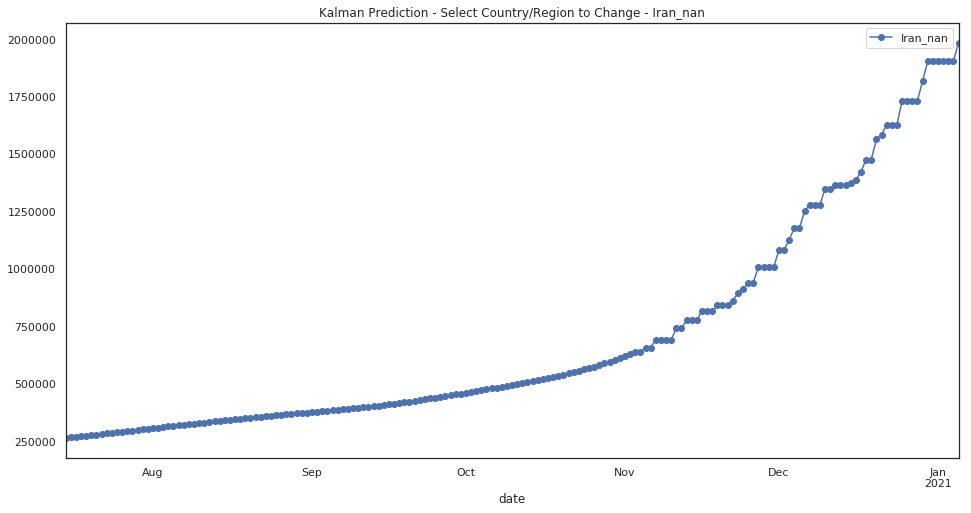

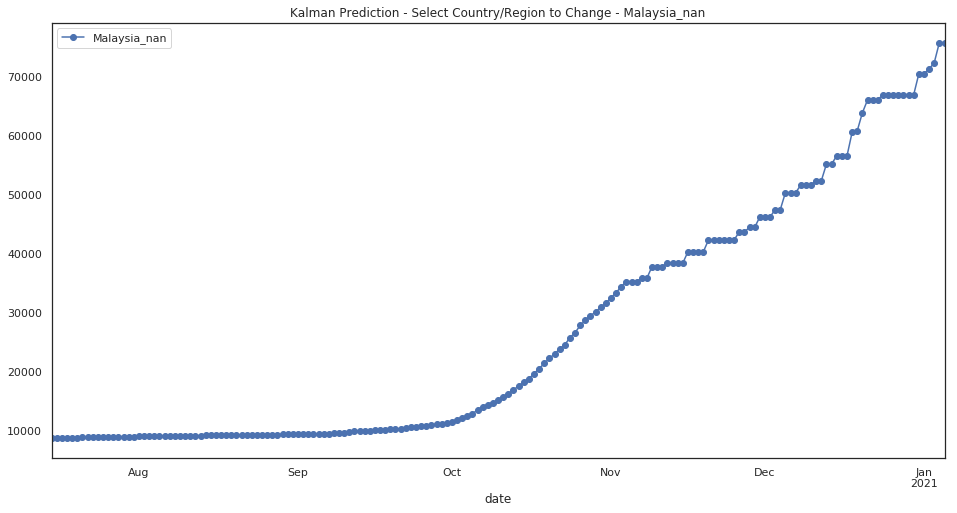

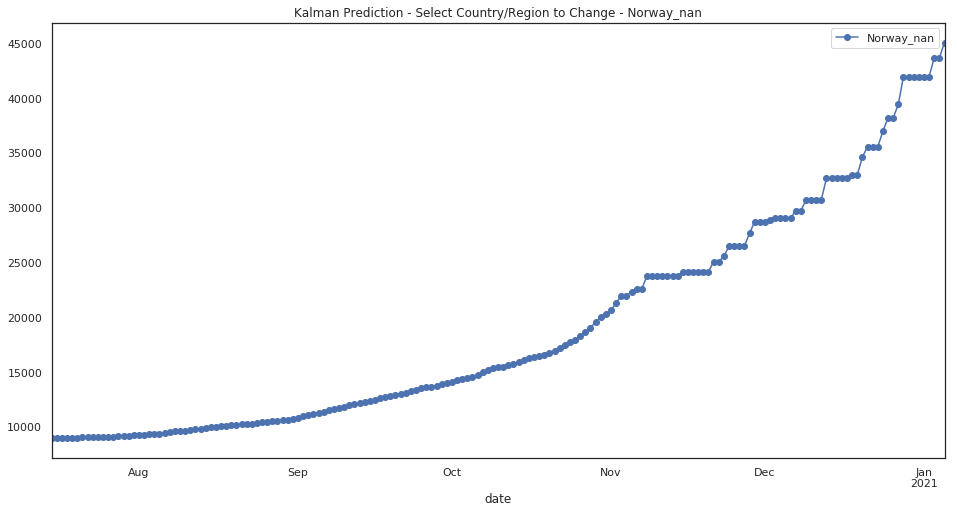

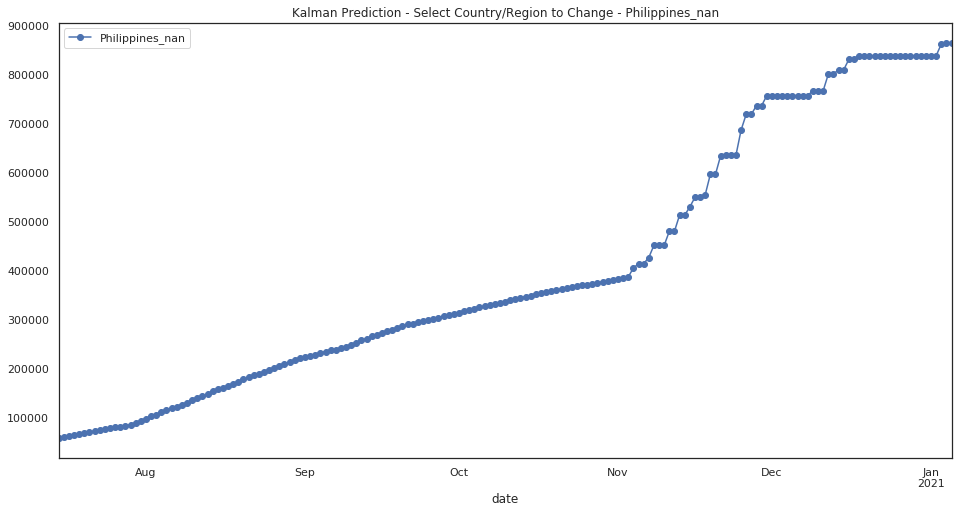

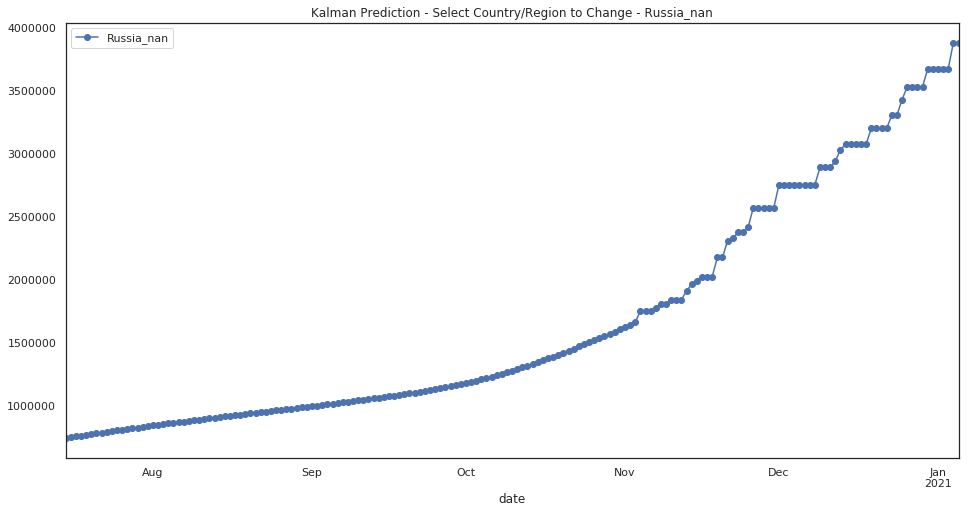

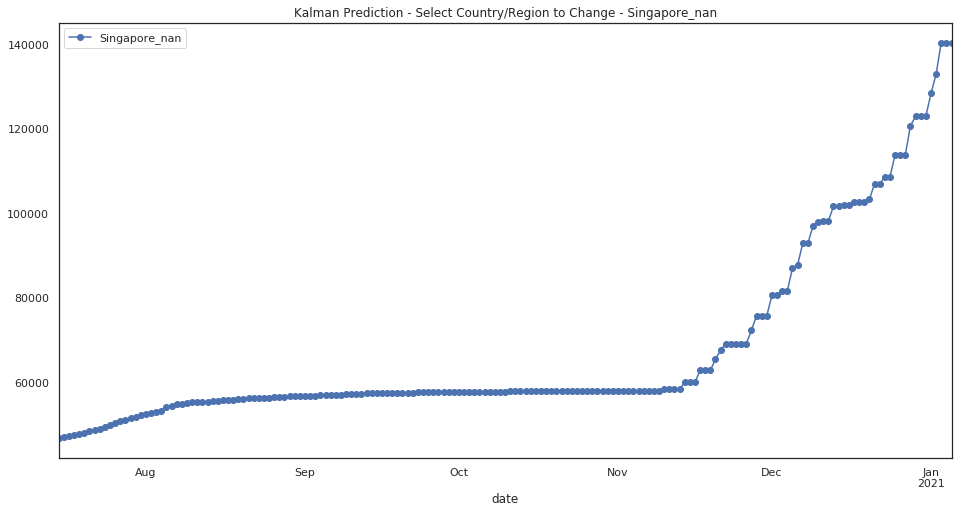

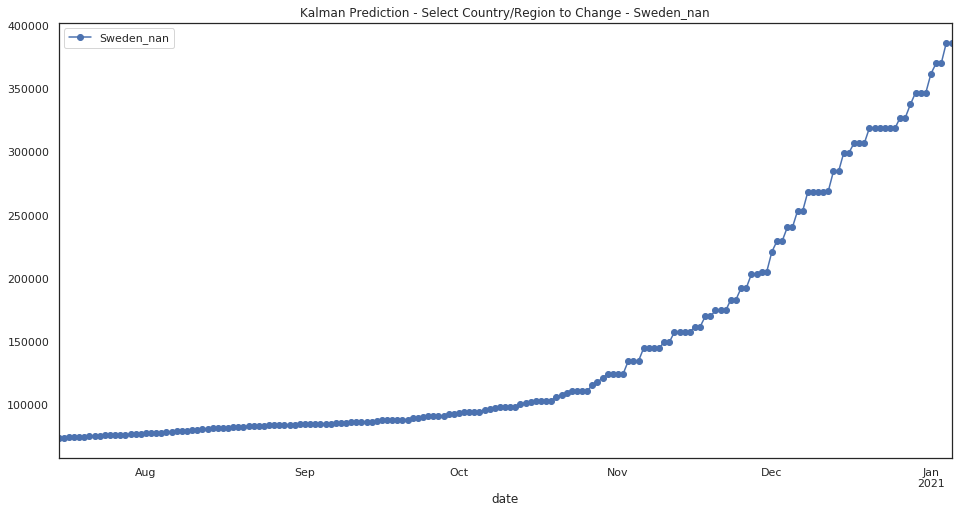

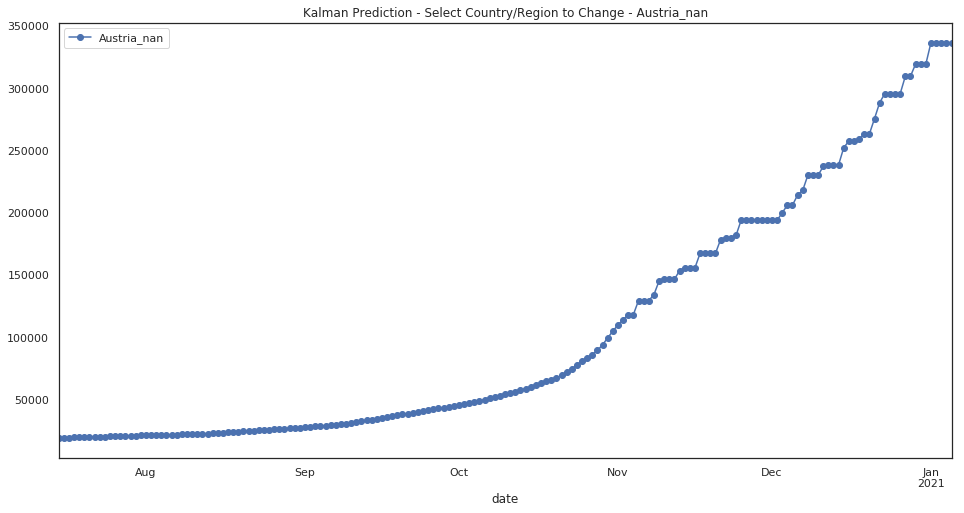

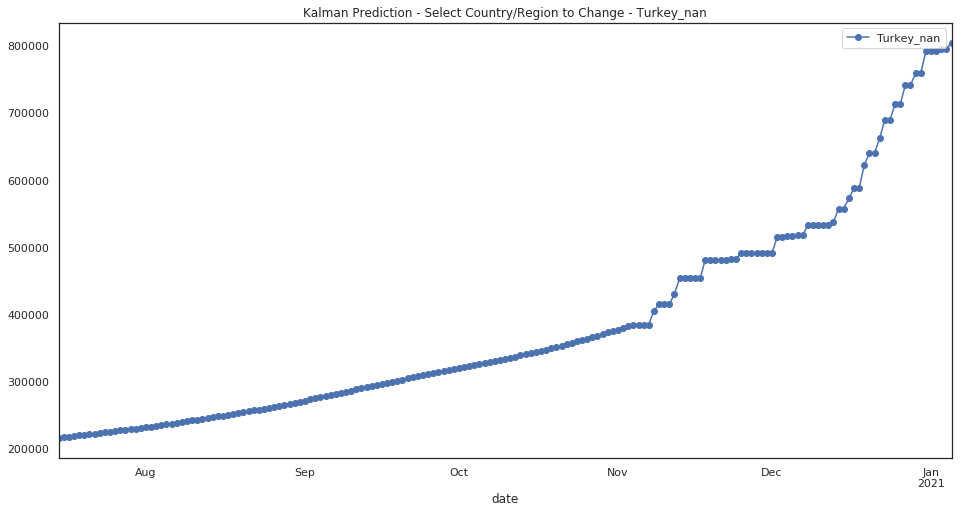

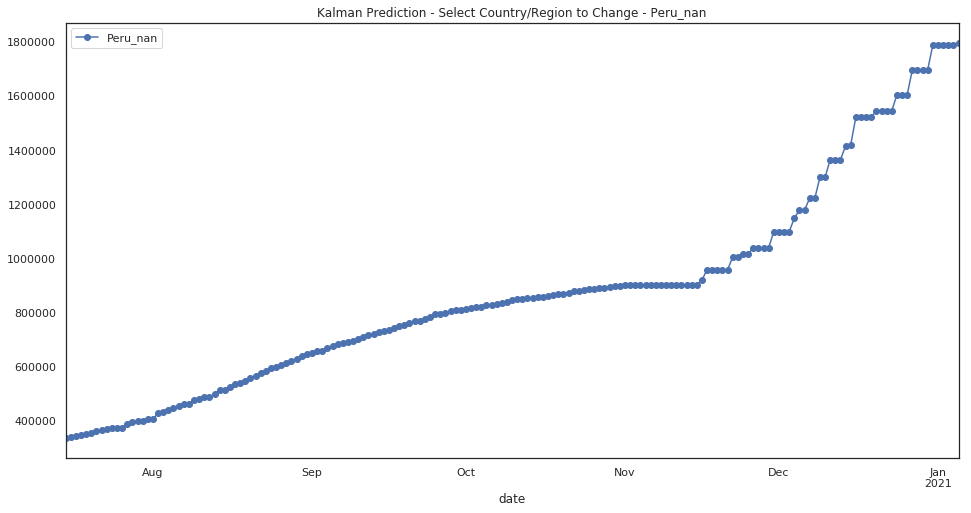

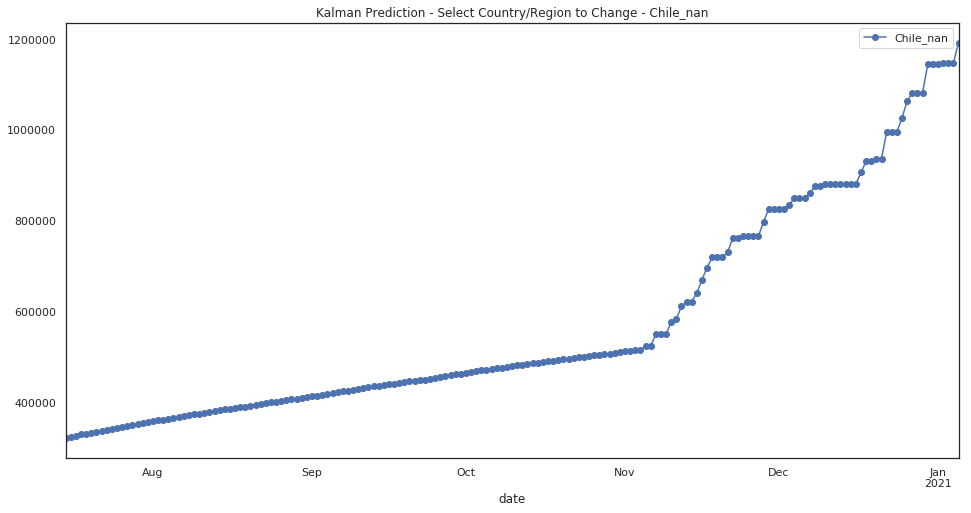

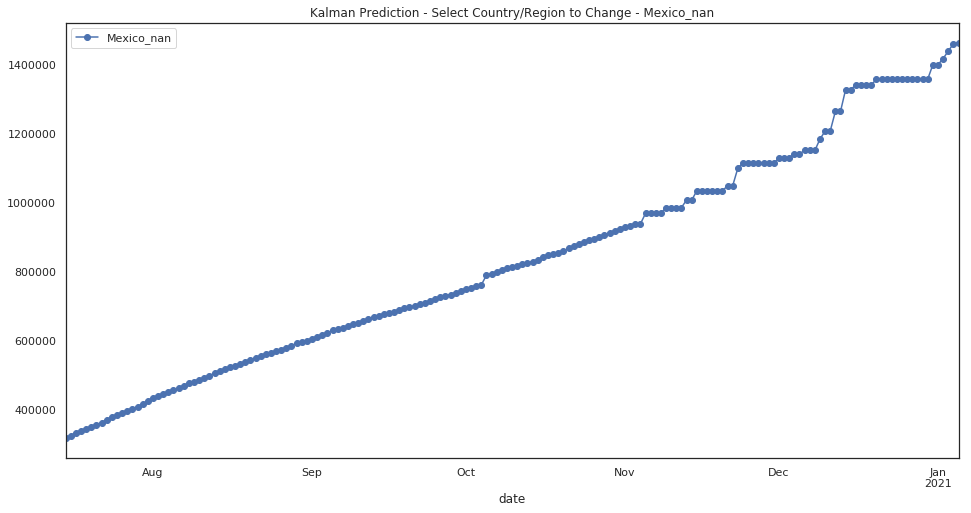

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-01-05 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      24306843.0
India_nan                                   NaN      12260174.0
Brazil_nan                                  NaN      11577675.0
Russia_nan                                  NaN       3881174.0
Spain_nan                                   NaN       3590089.0
France_nan                                  NaN       3009126.0
Colombia_nan                                NaN       2602007.0
Argentina_nan                               NaN       2597648.0
Italy_nan                                   NaN       2386736.0
United Kingdom_nan                          NaN       2241385.0
Iran_nan                                    NaN       1984963.0
Peru_nan                                    NaN       1797156.0
Mexico_nan                                  NaN       1464677.0
Iraq_nan                                    NaN       1350058.0
Pakistan_nan                                NaN       1253059.0
Chile_nan                                   NaN       1192801.0
Belgium_nan                                 NaN       1181375.0
Czechia_nan                                 NaN       1165927.0
Germany_nan                                 NaN       1149101.0
Poland_nan                                  NaN       1143731.0
South Africa_nan                            NaN       1109649.0
Netherlands_nan                             NaN       1072375.0
Romania_nan                                 NaN        932817.0
Indonesia_nan                               NaN        932205.0
Ukraine_nan                                 NaN        931287.0
Philippines_nan                             NaN        864830.0
Saudi Arabia_nan                            NaN        838692.0
Bangladesh_nan                              NaN        805344.0
Turkey_nan                                  NaN        804983.0
Morocco_nan                                 NaN        638825.0
...                                         ...             ...
France_Saint Barthelemy                     NaN           202.0
Saint Vincent and the Grenadines_nan        NaN           190.0
China_Ningxia                               NaN           182.0
United Kingdom_British Virgin Islands       NaN           134.0
Canada_Prince Edward Island                 NaN           118.0
Dominica_nan                                NaN           107.0
Australia_Northern Territory                NaN            69.0
Fiji_nan                                    NaN            68.0
China_Macau                                 NaN            64.0
Laos_nan                                    NaN            61.0
Canada_Yukon                                NaN            60.0
Grenada_nan                                 NaN            51.0
Holy See_nan                                NaN            51.0
Timor-Leste_nan                             NaN            49.0
France_New Caledonia                        NaN            48.0
Denmark_Greenland                           NaN            45.0
Solomon Islands_nan                         NaN            39.0
Saint Kitts and Nevis_nan                   NaN            38.0
China_Qinghai                               NaN            27.0
United Kingdom_Falkland Islands (Malvinas)  NaN            25.0
France_Saint Pierre and Miquelon            NaN            24.0
United Kingdom_Montserrat                   NaN            21.0
Canada_Grand Princess                       NaN            14.0
Canada_Northwest Territories                NaN            10.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             3.0
Marshall Islands_nan                        NaN             2.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[268 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          46029.0      18868.0      33663.0      16355.0   
2020-07-16          46095.0      18954.0      34172.0      16368.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23084.0        880.0   
2020-07-21          35526.0       4171.0      23691.0        884.0   
2020-07-22          35615.0       4290.0      24278.0        884.0   
2020-07-23          36047.0       4505.0      25438.0        950.0   
2020-07-24          36103.0       4474.0      26103.0       1038.0   
2020-07-25          36185.0       4571.0      26701.0        900.0   
2020-07-26          36297.0       4814.0      27328.0       1043.0   
2020-07-27          36392.0       4763.0      27951.0       1052.0   
2020-07-28          36501.0       4907.0      28586.0        907.0   
2020-07-29          36604.0       5028.0      29201.0       1067.0   
2020-07-30          36679.0       5159.0      29819.0        918.0   
2020-07-31          36808.0       5286.0      30394.0       1012.0   
2020-08-01          36846.0       5434.0      30963.0       1029.0   
2020-08-02          36868.0       5448.0      31487.0       1074.0   
2020-08-03          36906.0       5552.0      32007.0       1082.0   
2020-08-04          36934.0       5744.0      32538.0        937.0   
2020-08-05          36978.0       5809.0      33080.0       1059.0   
2020-08-06          37039.0       5924.0      33644.0       1092.0   
2020-08-07          37148.0       6102.0      34176.0       1011.0   
2020-08-08          37187.0       6218.0      34724.0        955.0   
2020-08-09          37206.0       6383.0      35200.0       1109.0   
2020-08-10          37308.0       6486.0      35757.0       1112.0   
2020-08-11          37397.0       6656.0      36242.0        972.0   
2020-08-12          37478.0       6768.0      36750.0       1120.0   
2020-08-13          37562.0       6923.0      37238.0        977.0   
...                     ...          ...          ...          ...   
2020-12-08          66361.0      45225.0      75878.0       8118.0   
2020-12-09          66747.0      45397.0      75878.0       8504.0   
2020-12-10          66714.0      46862.0      75878.0       8504.0   
2020-12-11          66709.0      46919.0      75864.0       8853.0   
2020-12-12          66752.0      47036.0      75837.0       9206.0   
2020-12-13          66747.0      47020.0      75837.0       9206.0   
2020-12-14          66747.0      47020.0      77853.0       9206.0   
2020-12-15          66741.0      46989.0      78256.0       9206.0   
2020-12-16          66714.0      46989.0      78134.0       9573.0   
2020-12-17          66714.0      46989.0      78134.0       9732.0   
2020-12-18          66714.0      46968.0      79068.0      10172.0   
2020-12-19          66714.0      46968.0      79253.0      10172.0   
2020-12-20          66714.0      48516.0      81891.0      10369.0   
2020-12-21          67370.0      48677.0      82458.0      10369.0   
2020-12-22          67480.0      49479.0      82283.0      10369.0   
2020-12-23          67463.0      51295.0      82841.0      10499.0   
2020-12-24          68273.0      52644.0      84719.0      10749.0   
2020-12-25          68423.0      53877.0      88577.0      10749.0   
2020-12-26          68399.0      55913.0      89224.0      11162.0   
2020-12-27          70918.0      56997.0      90575.0      11162.0   
2020-12-28          73063.0      58397.0      90971.0      11695.0   
2020-12-29          73287.0      58586.0      96147.0      11695.0   
2020-12-30          74567.0      60835.0      97408.0      11695.0   
2020-12-31          76911.0      61110.0      96897.0      11867.0   
2021-01-01

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'Spain_nan',
 'France_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Italy_nan',
 'United Kingdom_nan',
 'Iran_nan',
 'Peru_nan',
 'Mexico_nan',
 'Iraq_nan',
 'Pakistan_nan',
 'Chile_nan',
 'Belgium_nan',
 'Czechia_nan',
 'Germany_nan',
 'Poland_nan',
 'South Africa_nan',
 'Netherlands_nan',
 'Romania_nan',
 'Indonesia_nan',
 'Ukraine_nan',
 'Philippines_nan',
 'Saudi Arabia_nan',
 'Bangladesh_nan',
 'Turkey_nan',
 'Morocco_nan',
 'Switzerland_nan',
 'Israel_nan',
 'Ecuador_nan',
 'Sweden_nan',
 'Dominican Republic_nan',
 'Austria_nan',
 'Portugal_nan',
 'Oman_nan',
 'Nepal_nan',
 'Bolivia_nan',
 'Kazakhstan_nan',
 'Kuwait_nan',
 'Canada_Quebec',
 'Qatar_nan',
 'Panama_nan',
 'Guatemala_nan',
 'United Arab Emirates_nan',
 'Ethiopia_nan',
 'Venezuela_nan',
 'Croatia_nan',
 'Costa Rica_nan',
 'Bulgaria_nan',
 'Canada_Ontario',
 'Serbia_nan',
 'Jordan_nan',
 'Lebanon_nan',
 'Hungary_nan',
 'Moldova_nan',
 'Egypt_nan',
 'Tunisi

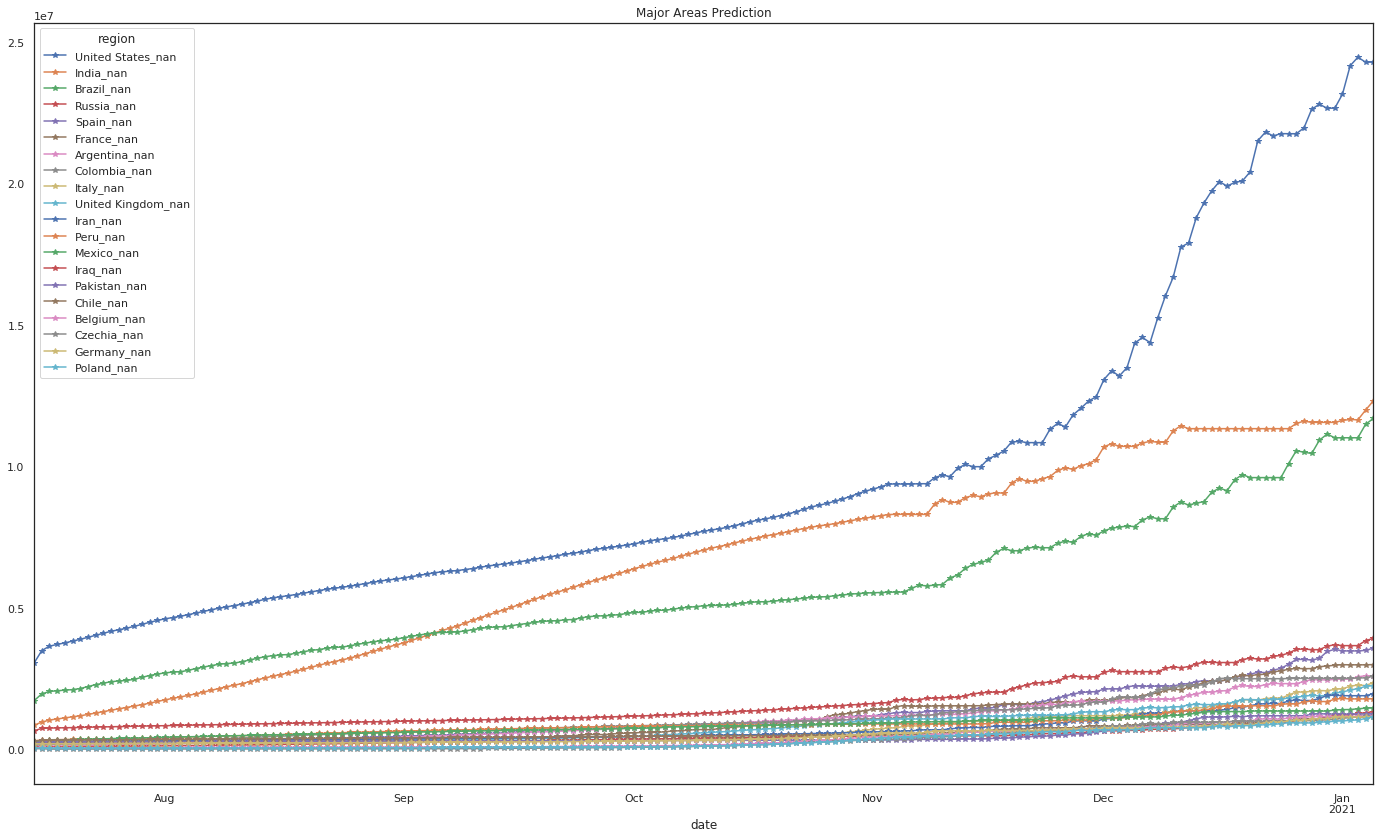

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

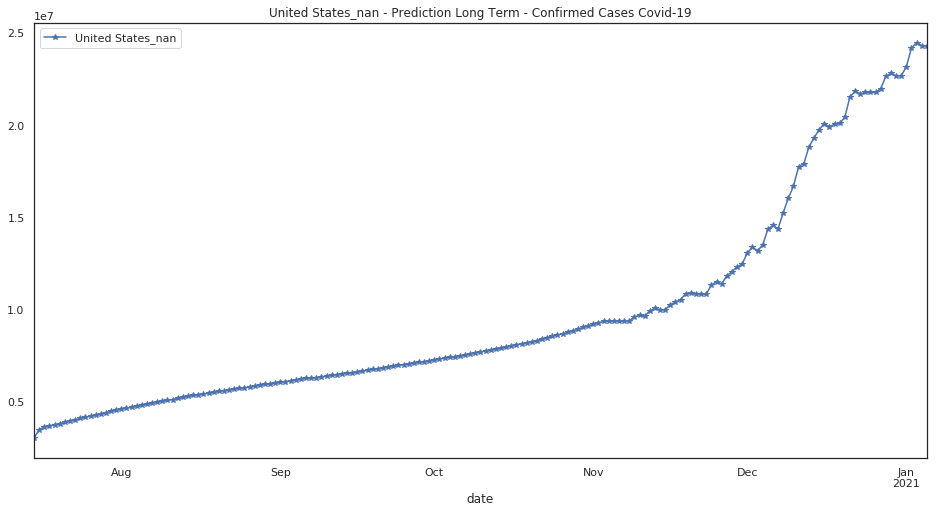

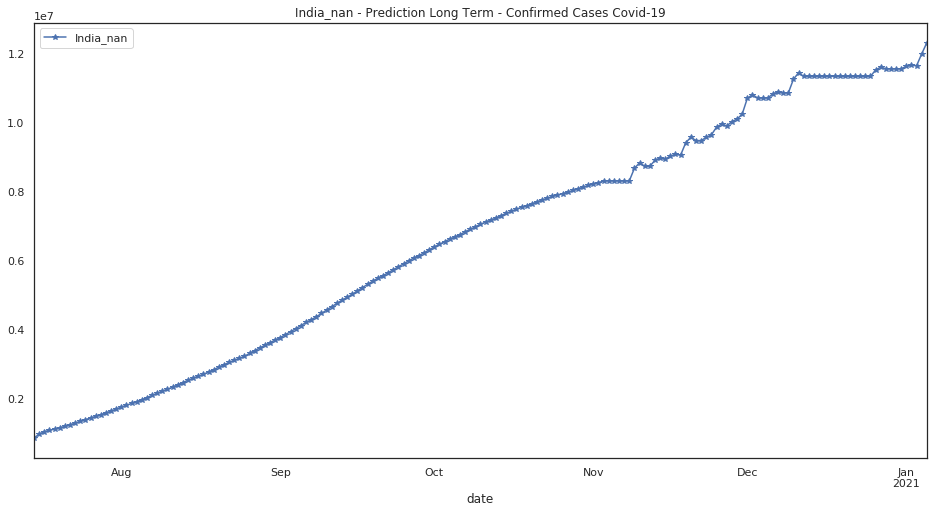

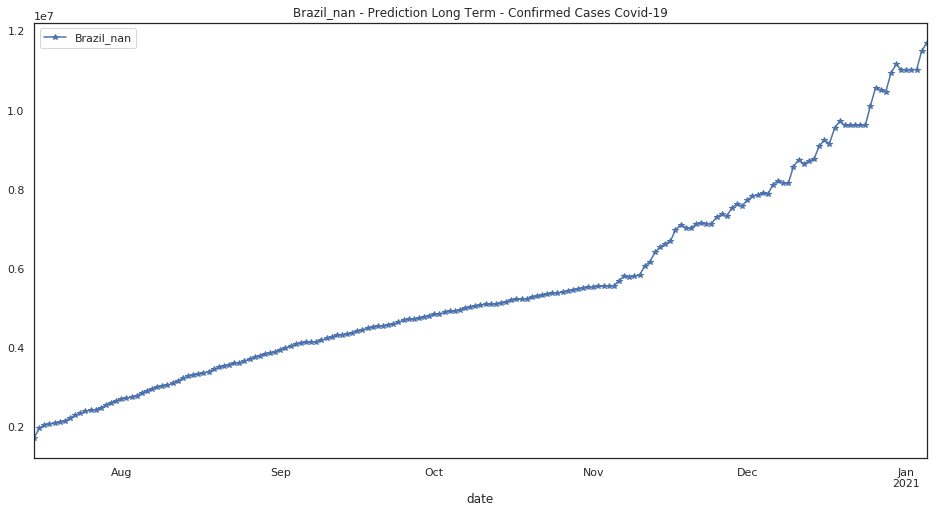

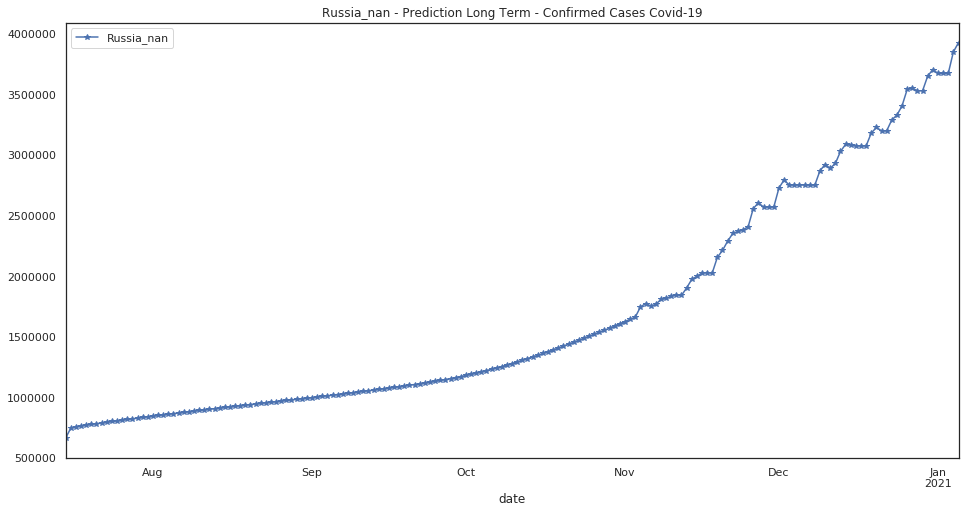

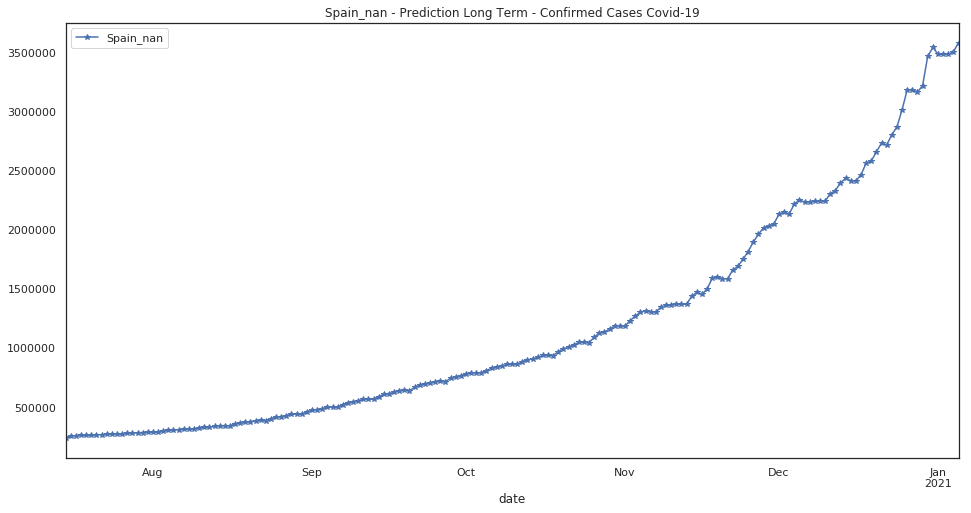

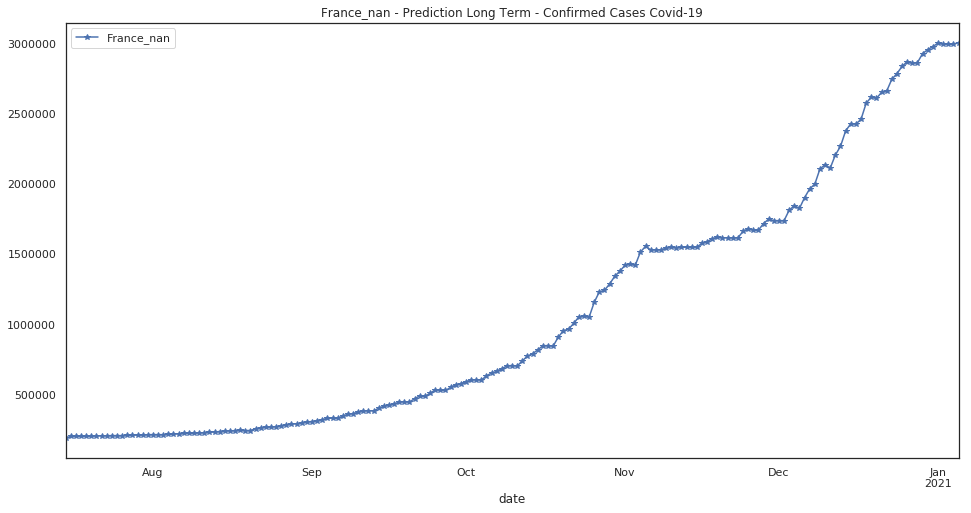

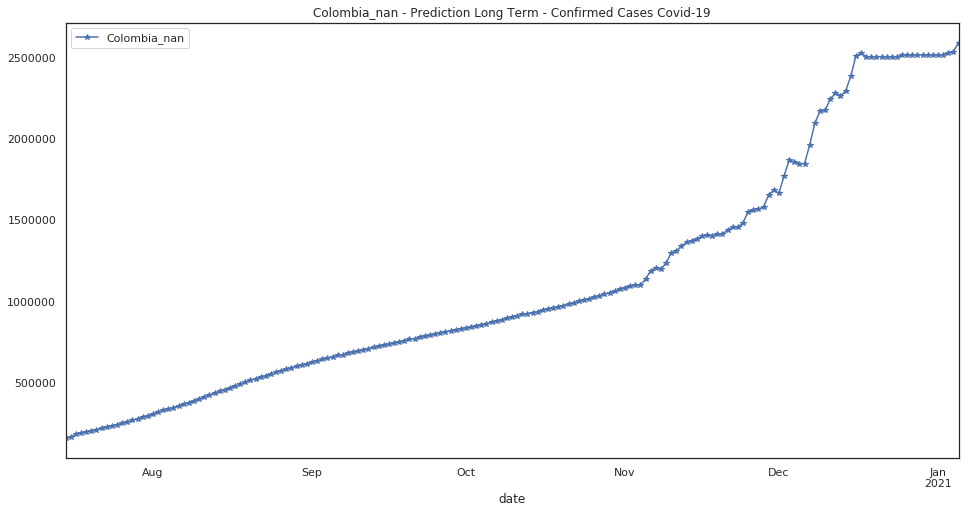

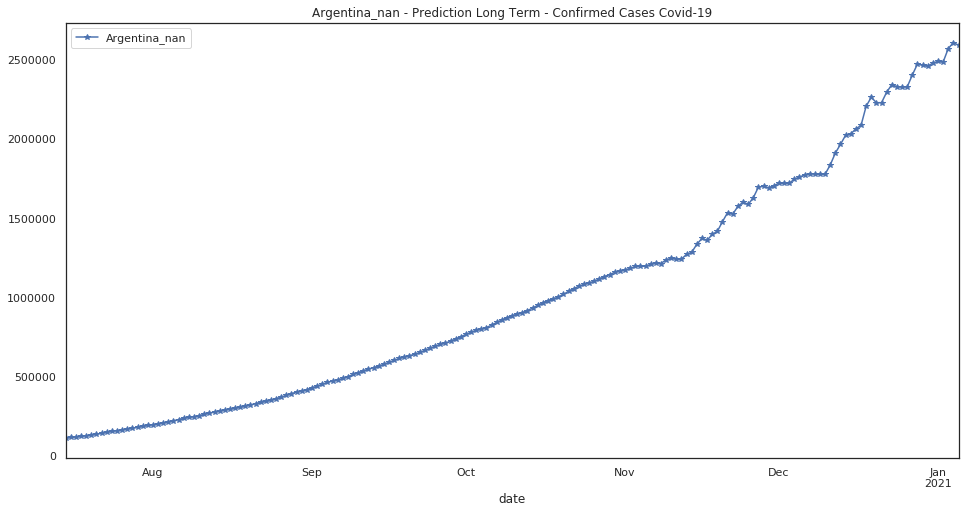

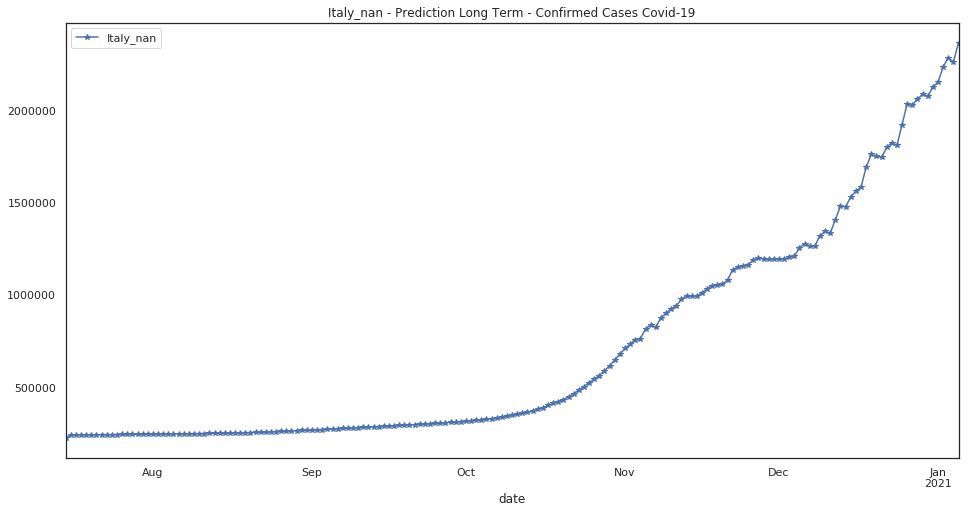

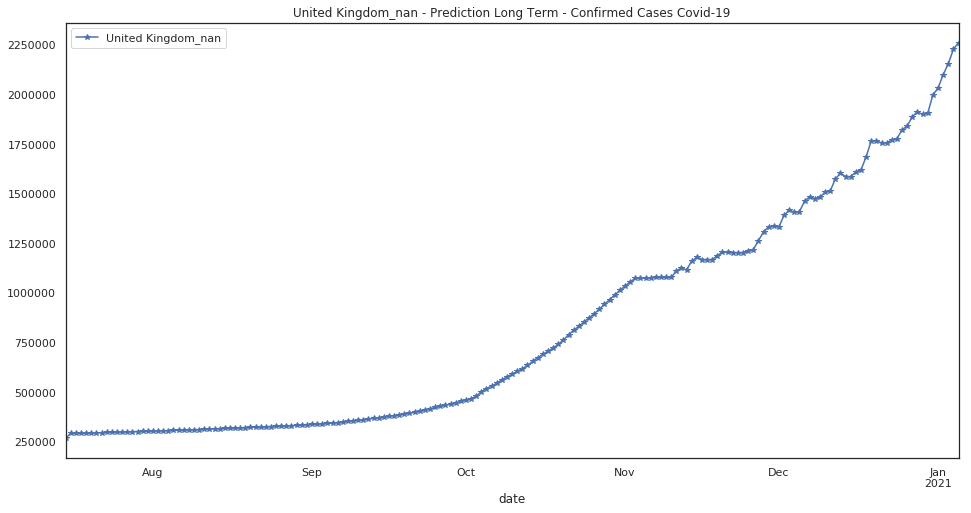

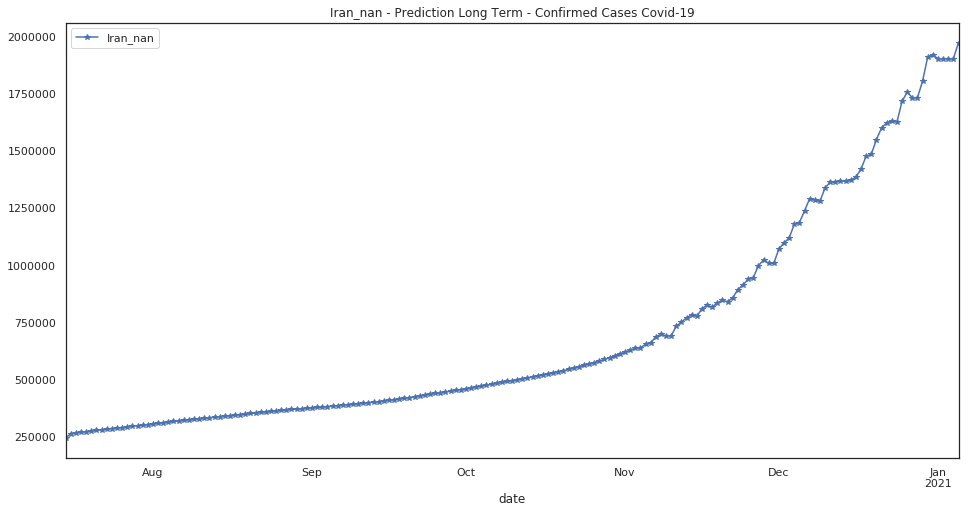

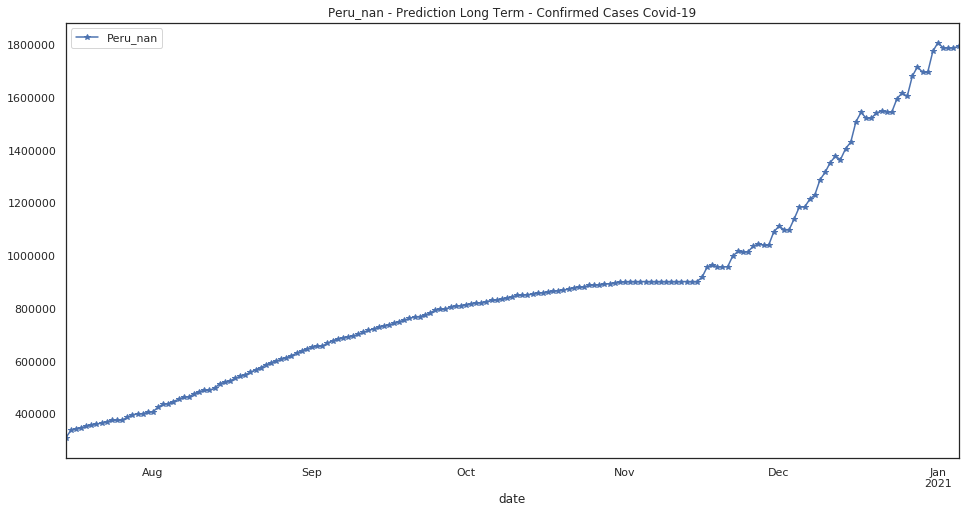

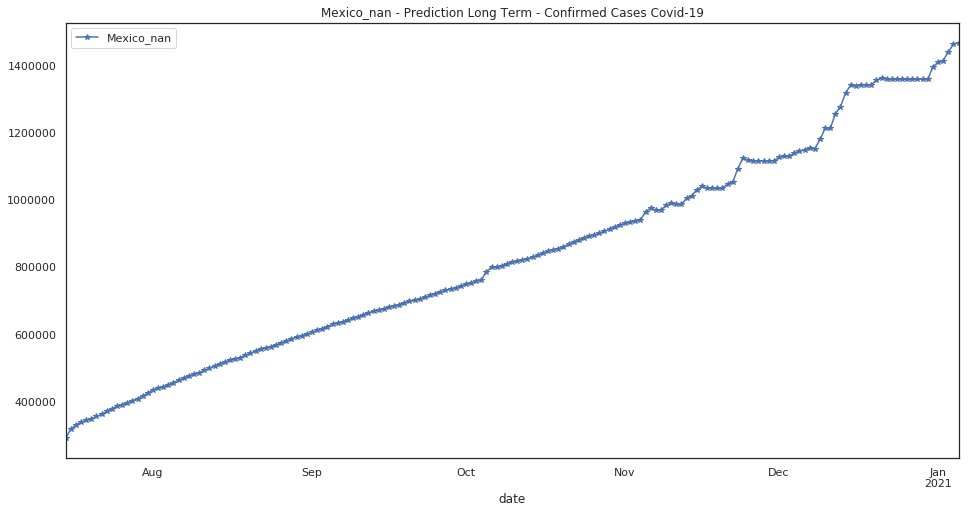

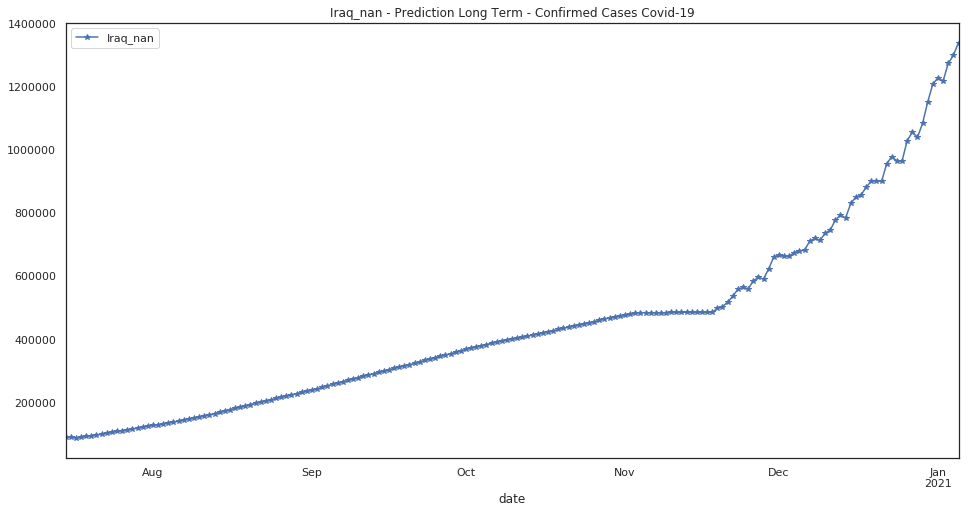

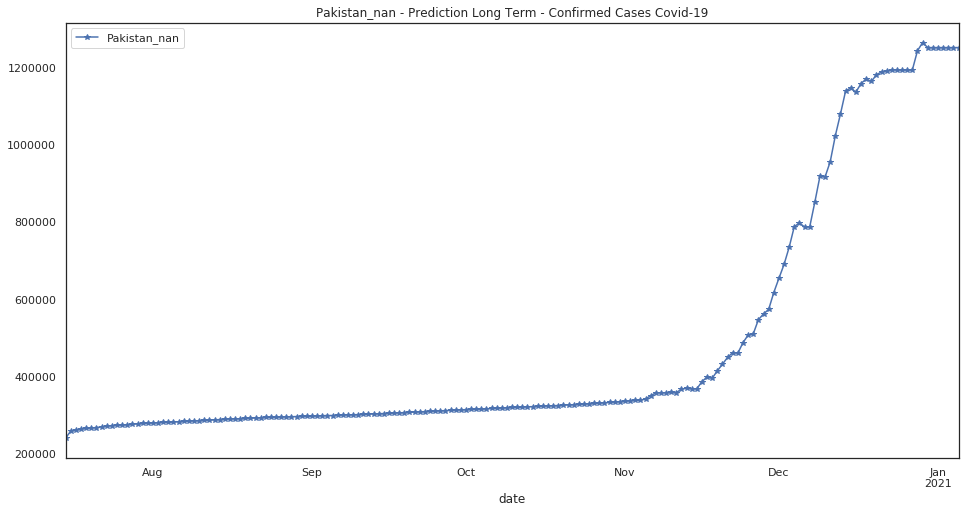

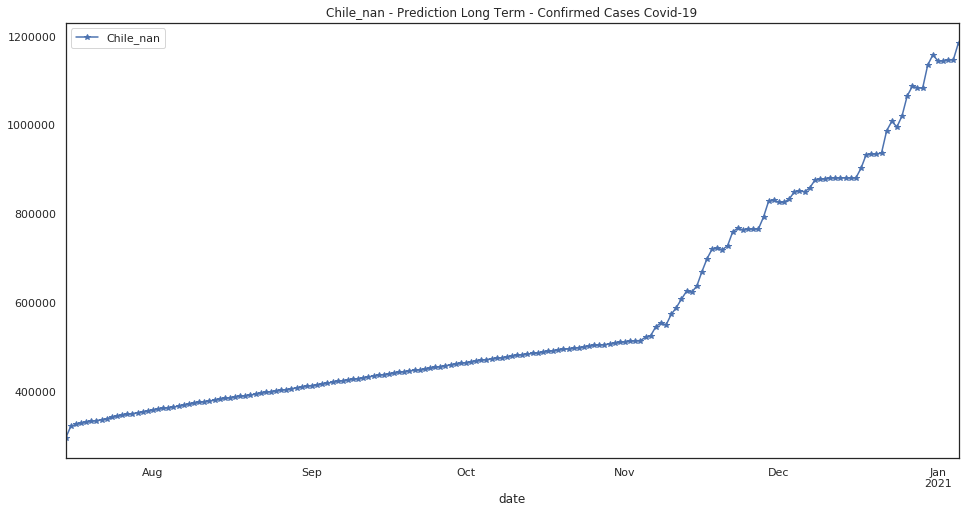

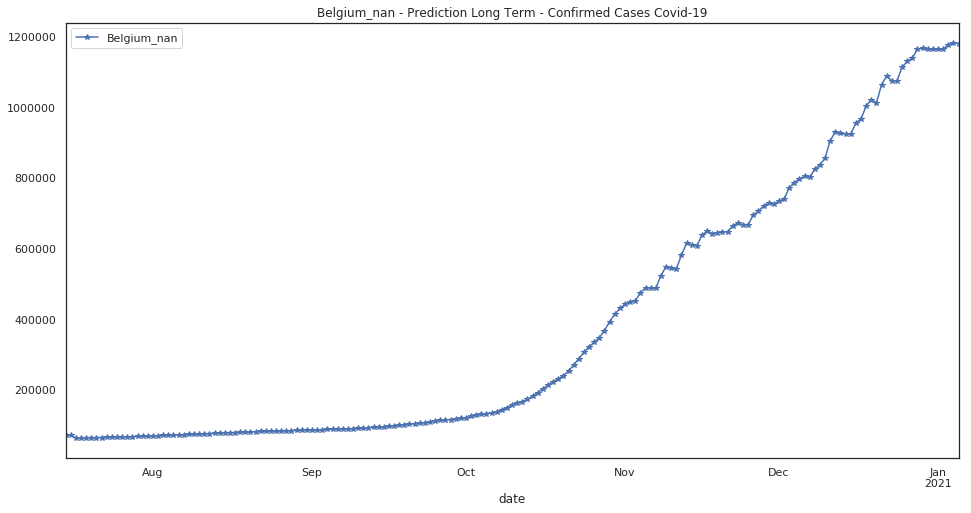

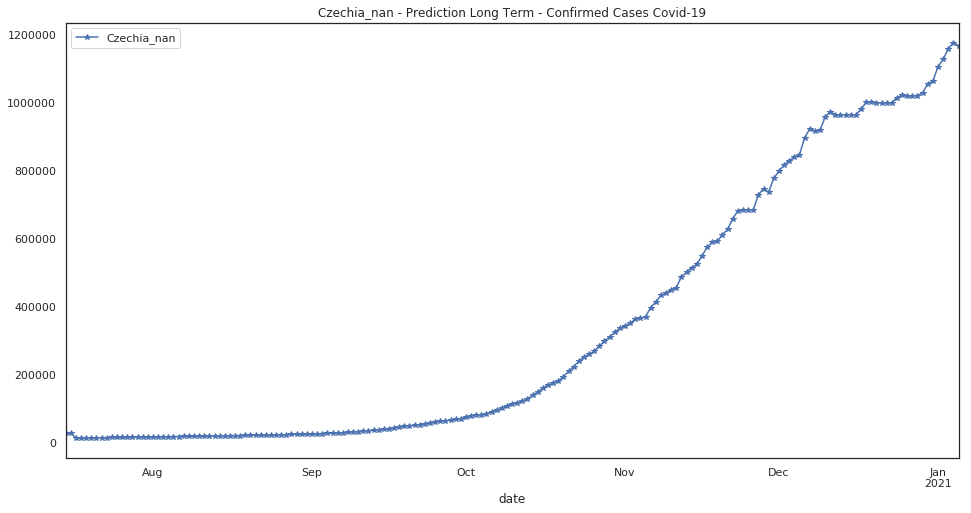

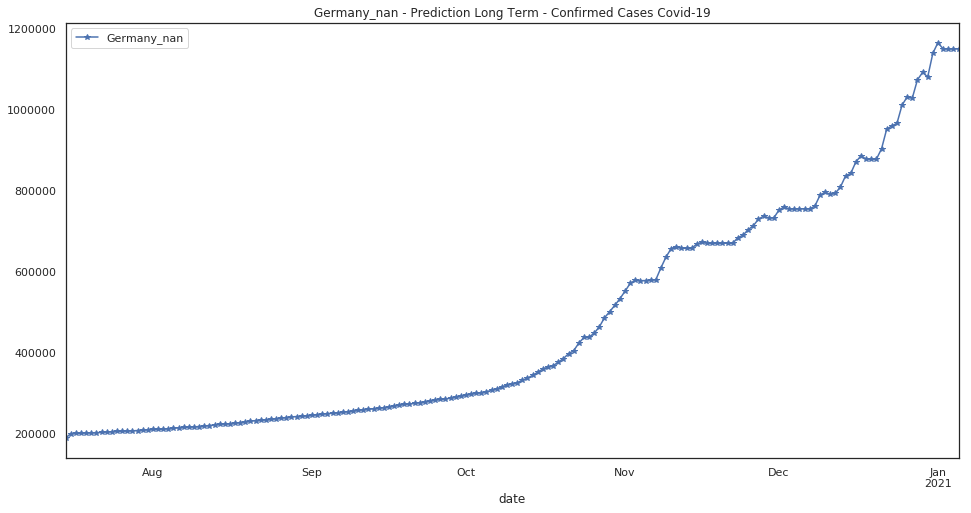

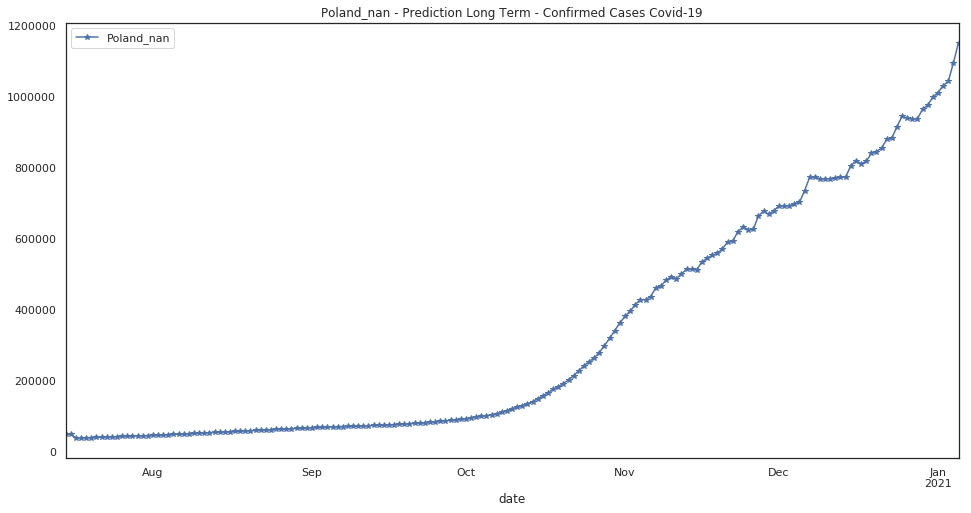

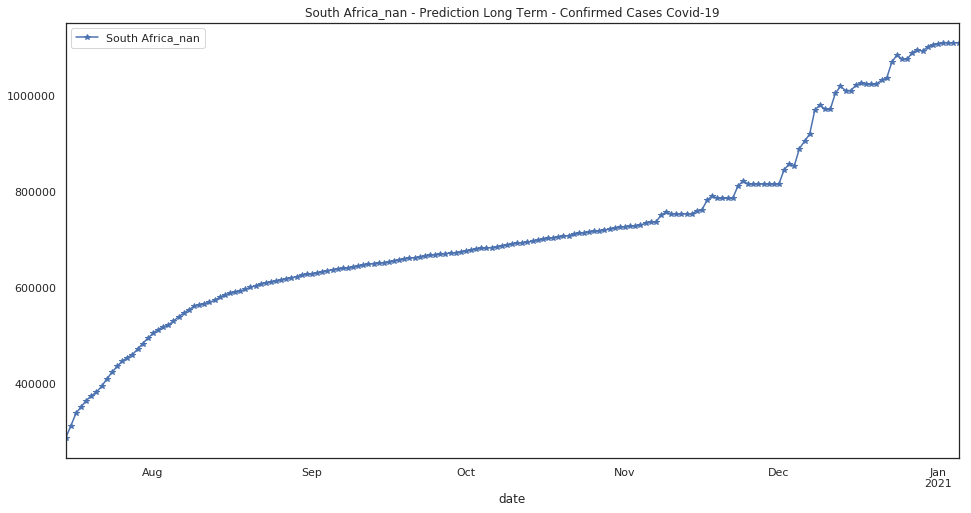

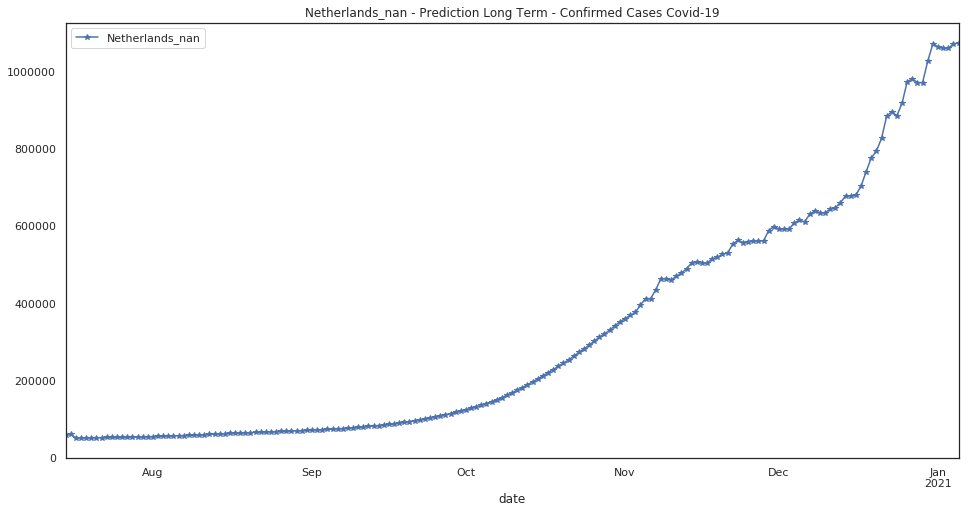

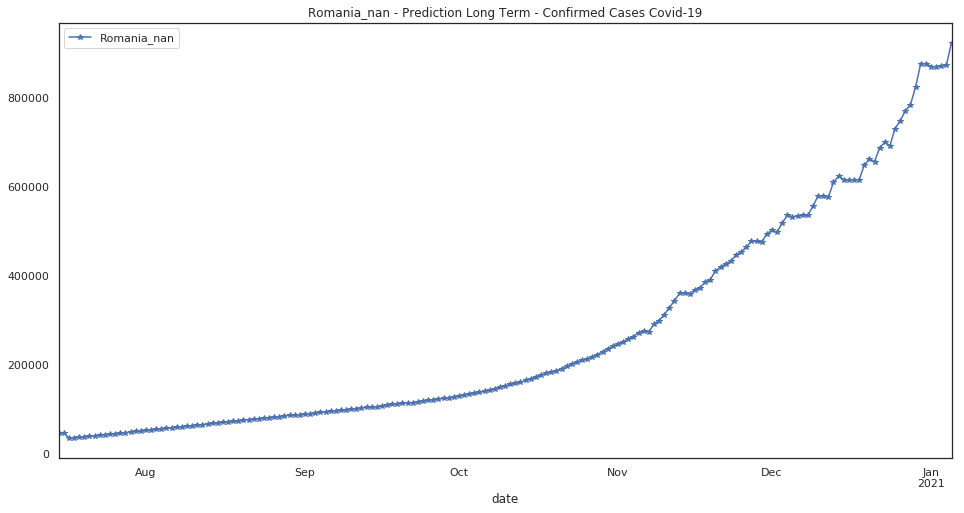

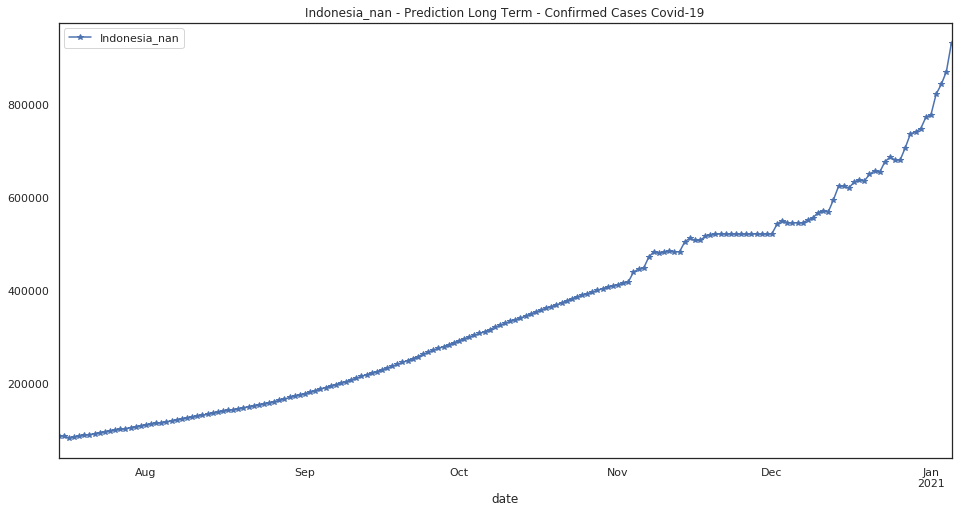

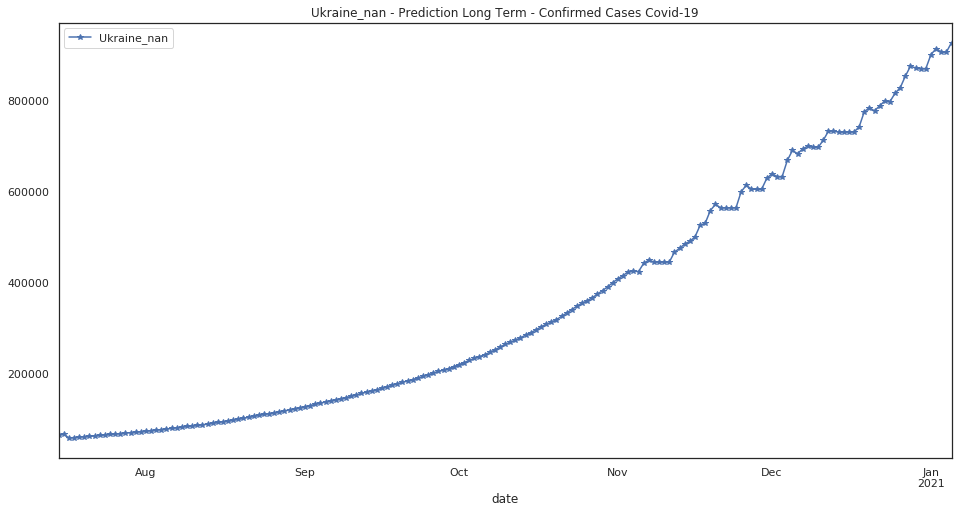

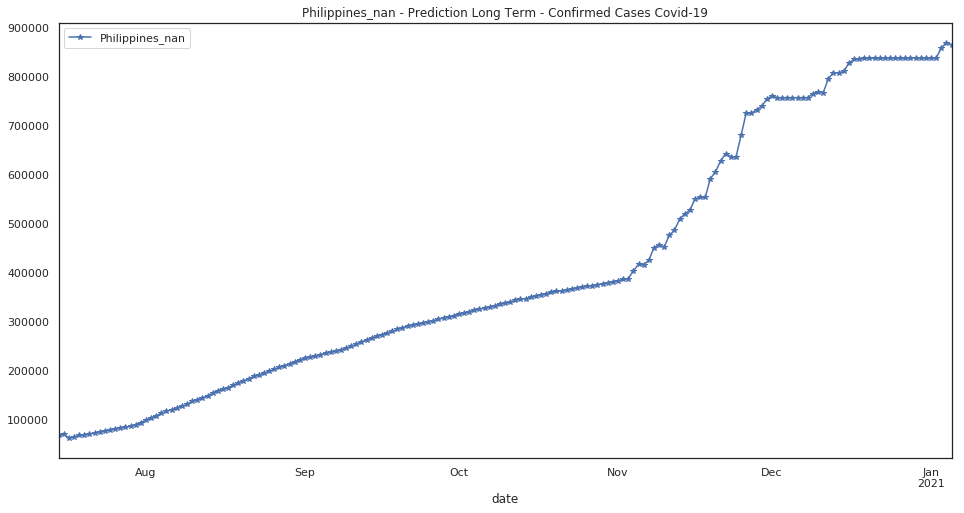

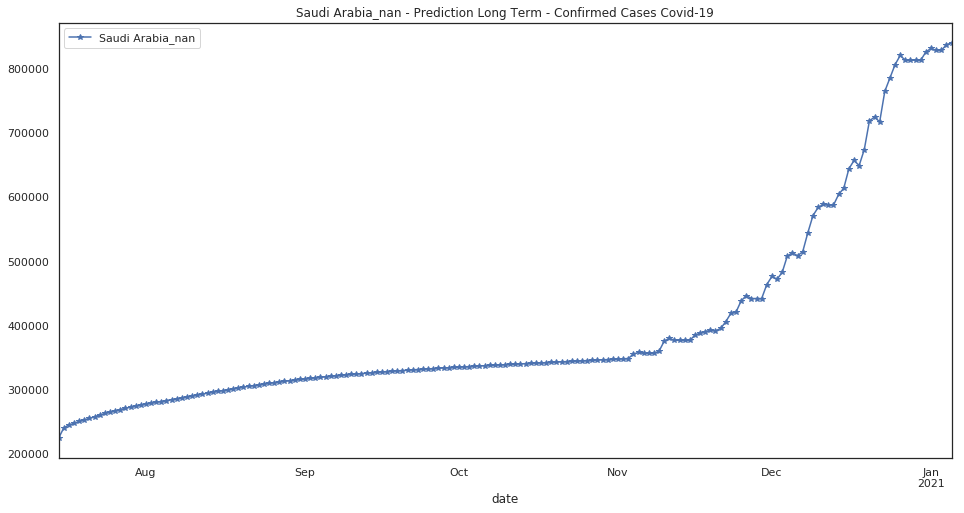

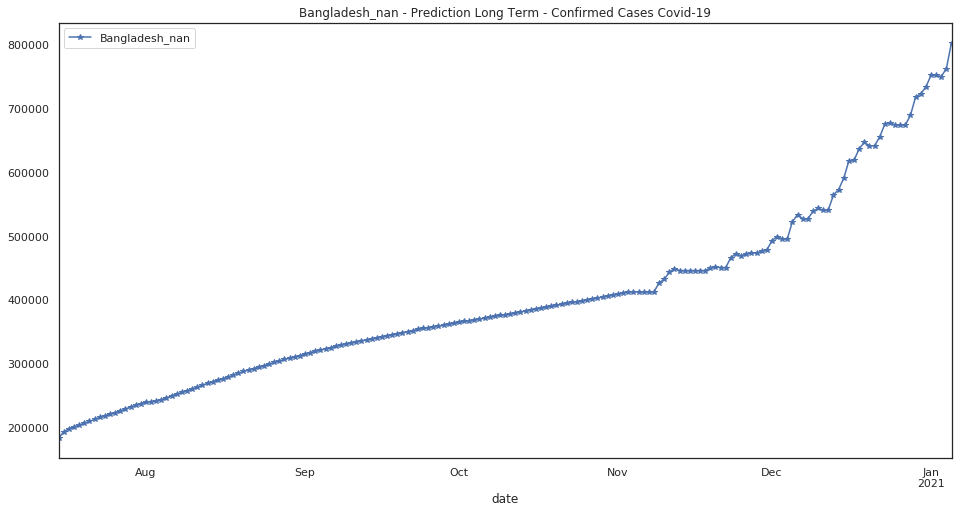

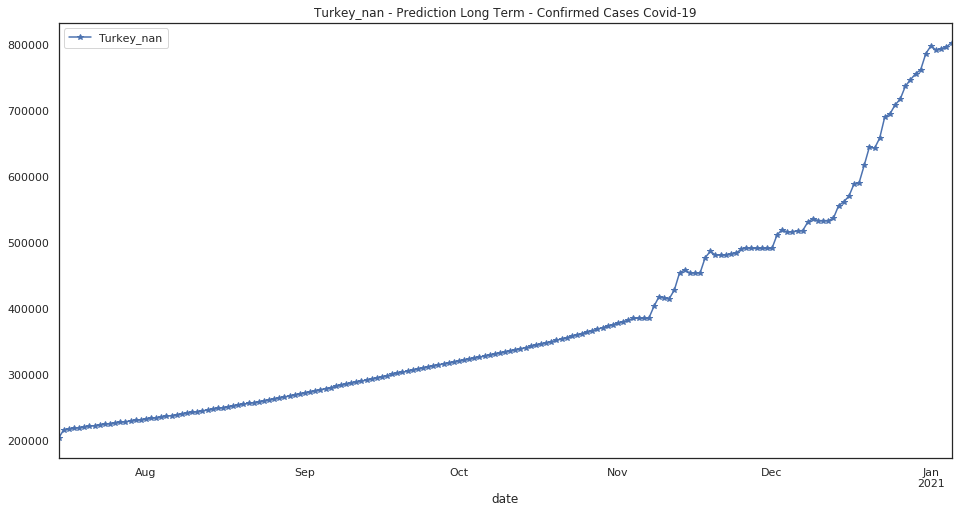

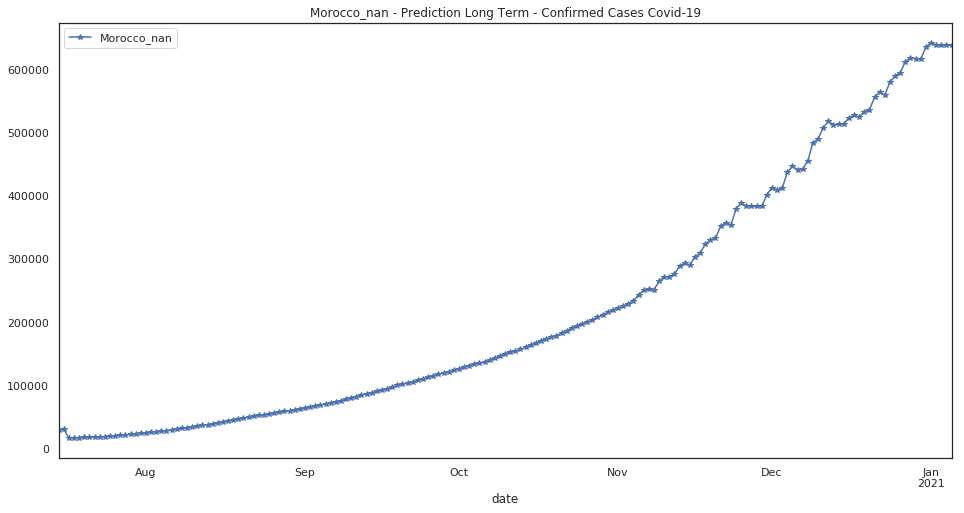

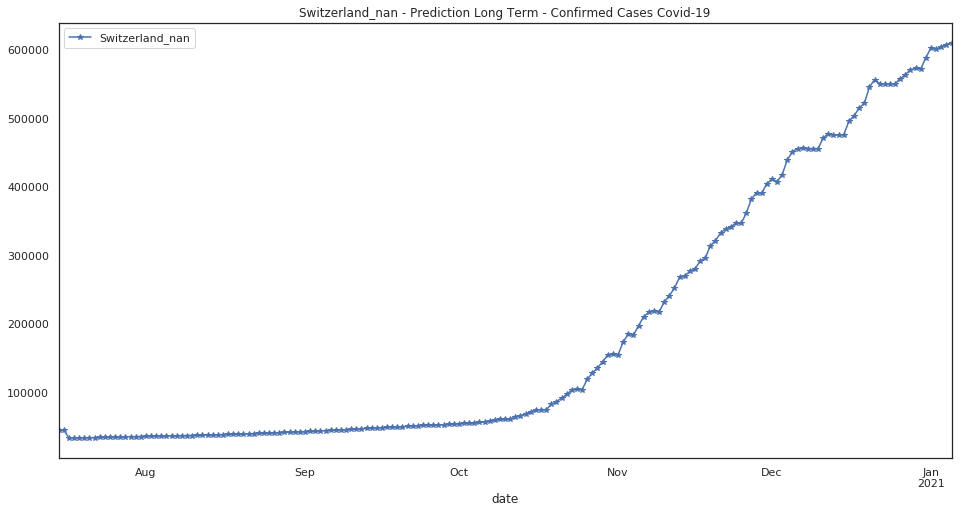

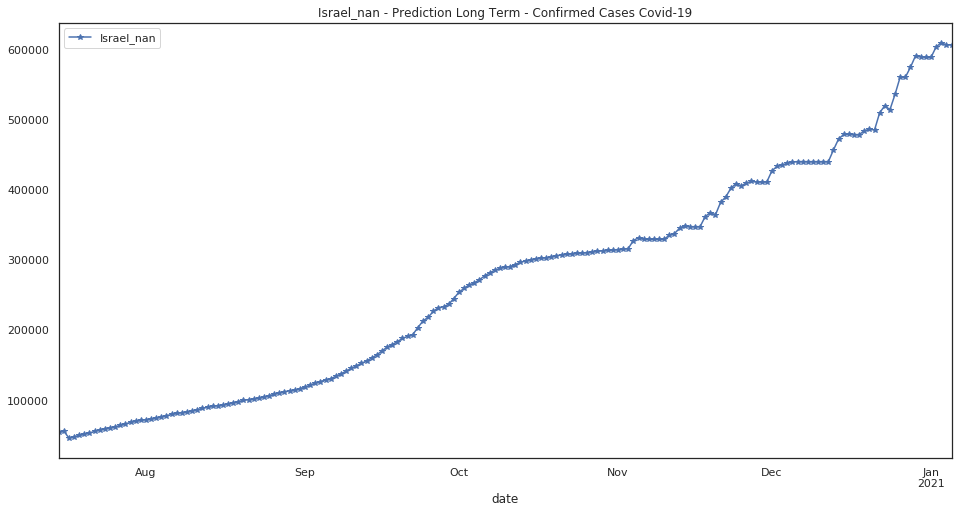

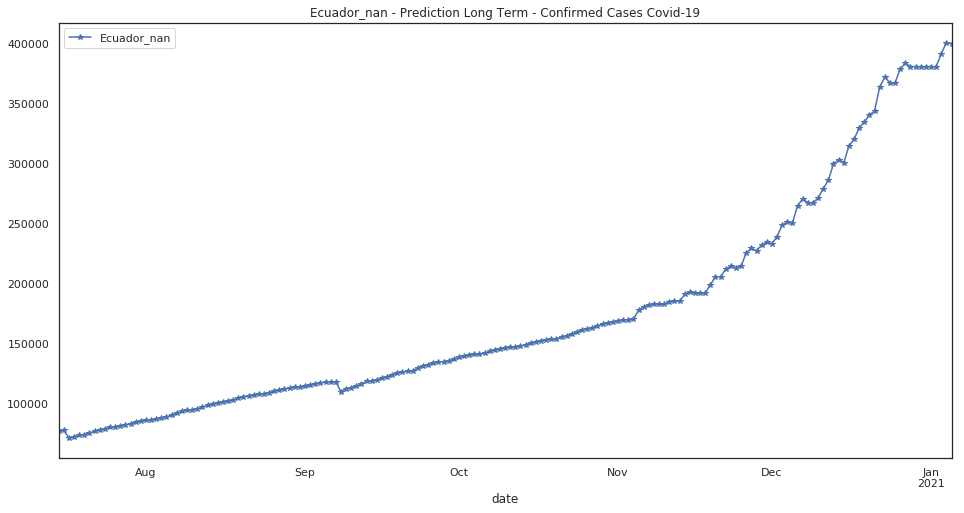

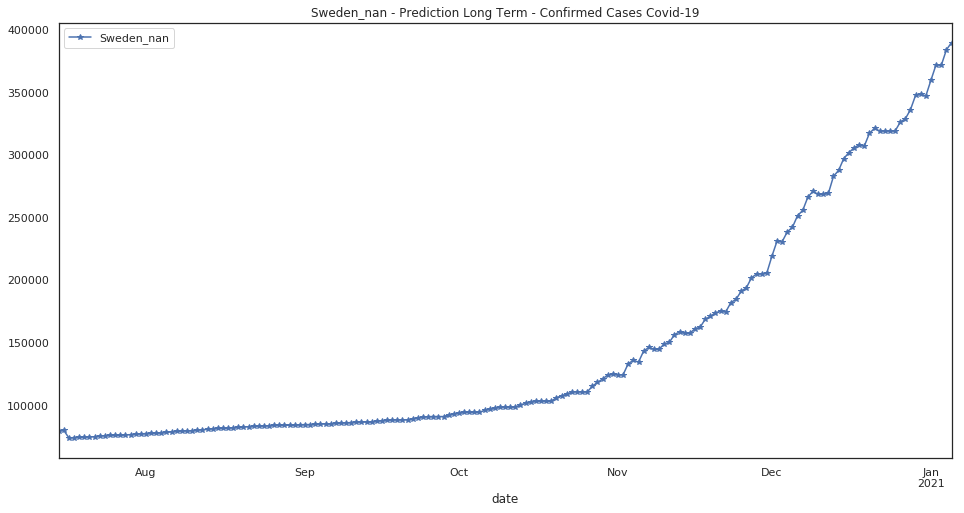

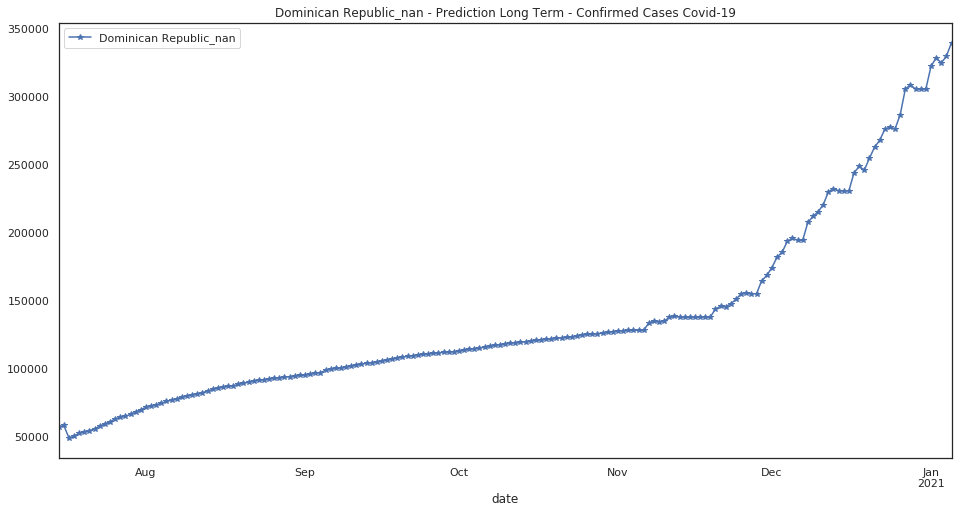

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

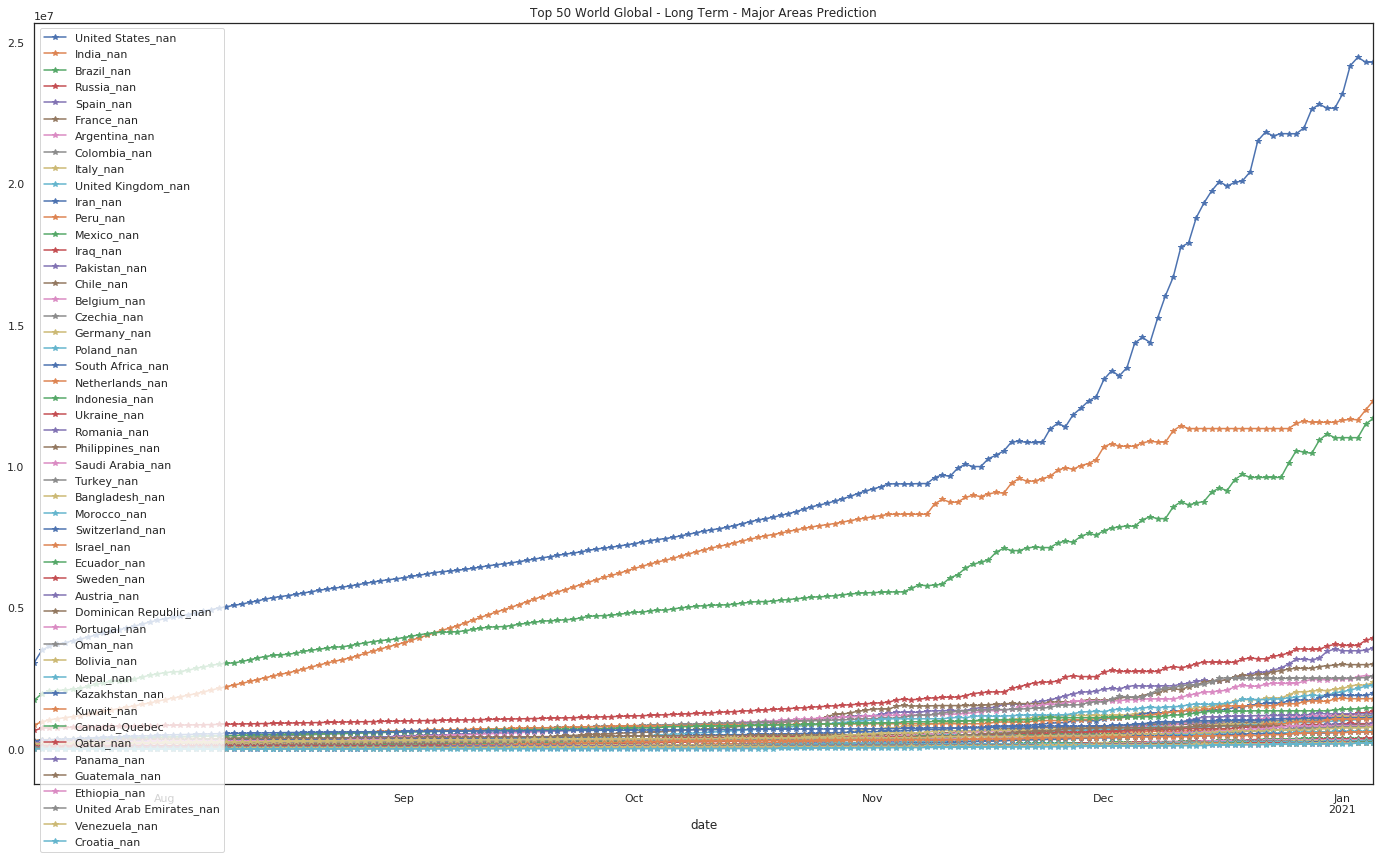

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

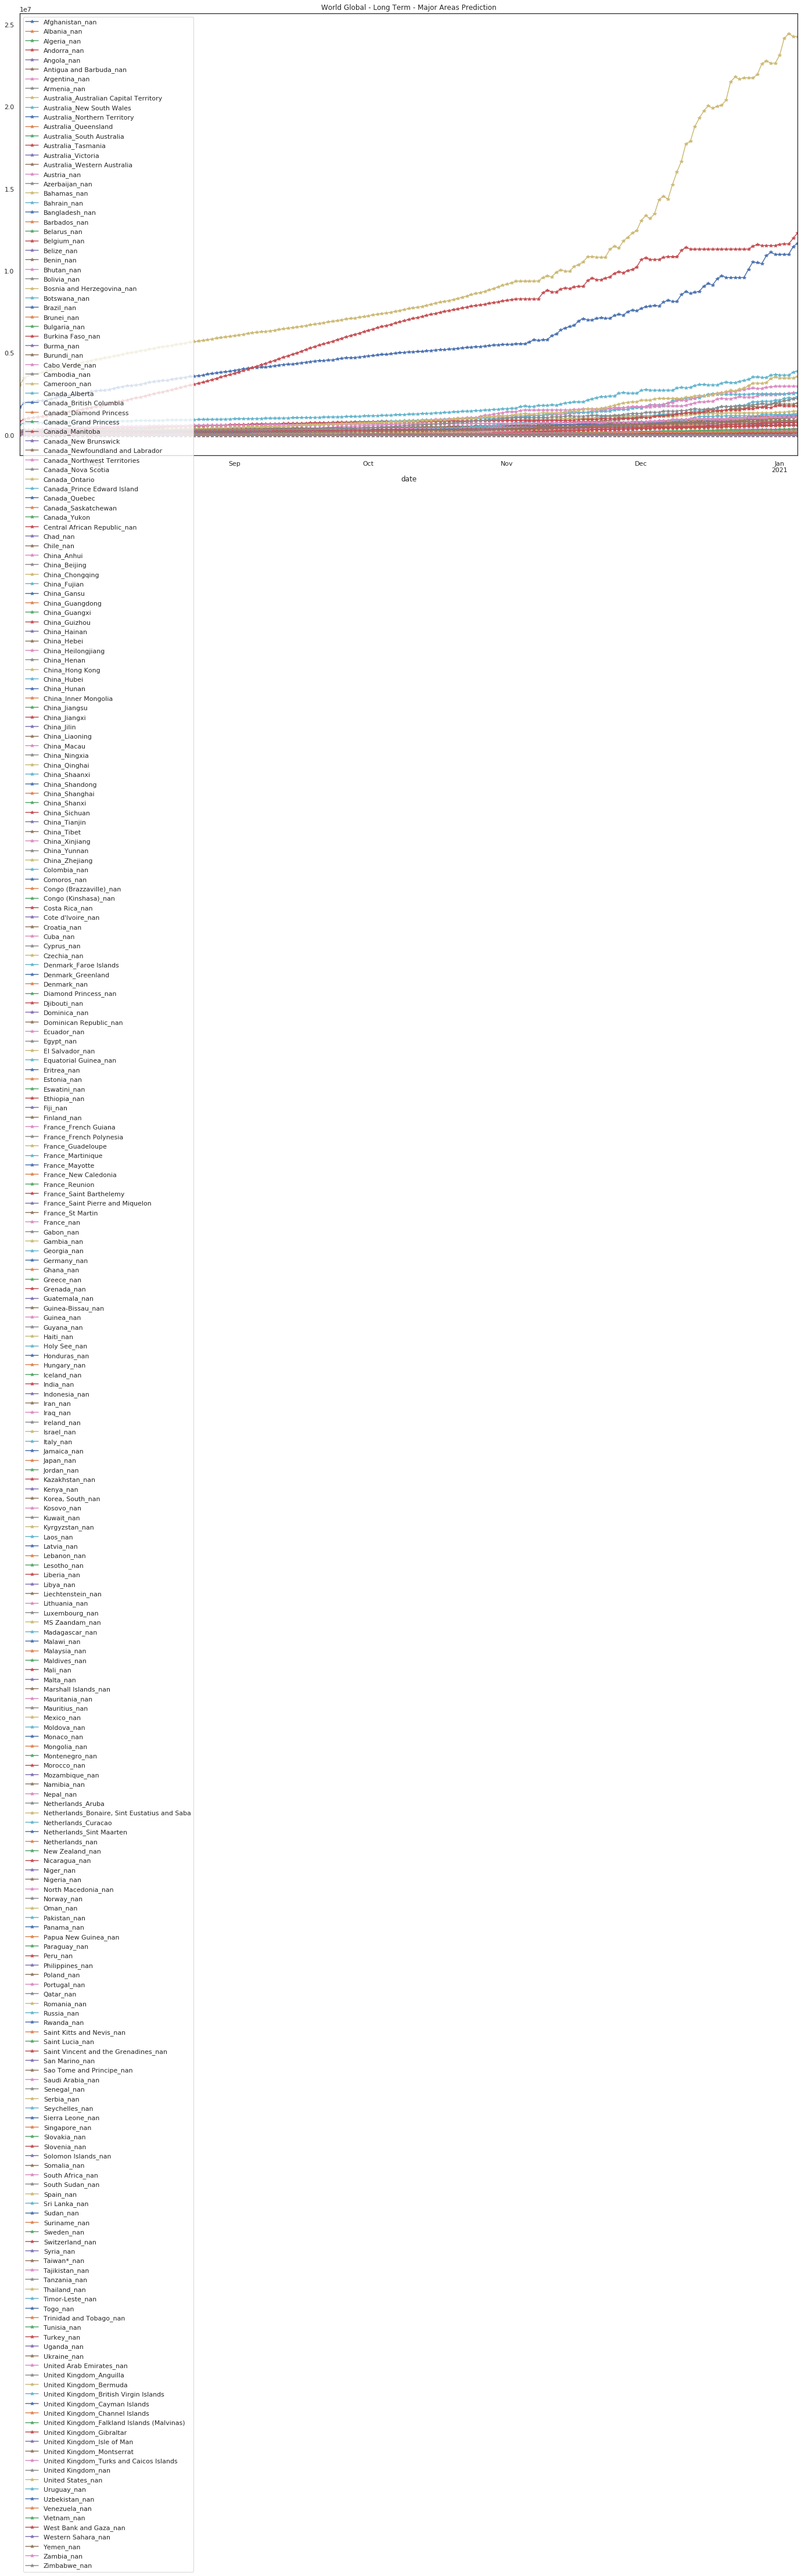

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38299.0       9350.0      43865.0       1124.0   
2020-08-30          38316.0       9484.0      44233.0       1292.0   
2020-08-31          38318.0       9581.0      44585.0       1338.0   
2020-09-01          38348.0       9630.0      44927.0       1176.0   
2020-09-02          38388.0       9806.0      45255.0       1290.0   
2020-09-03          38430.0       9879.0      45569.0       1199.0   
2020-09-04          38451.0      10008.0      45874.0       1382.0   
2020-09-05          38475.0      10134.0      46173.0       1215.0   
2020-09-06          38542.0      10273.0      46467.0       1374.0   
2020-09-07          38627.0      10406.0      46756.0       1414.0   
2020-09-08          38659.0      10561.0      47042.0       1261.0   
2020-09-09          38694.0      10722.0      47320.0       1459.0   
2020-09-10          38722.0      10875.0      47593.0       1301.0   
2020-09-11          38755.0      11034.0      47859.0       1505.0   
2020-09-12          38789.0      11196.0      48115.0       1344.0   
2020-09-13          38859.0      11363.0      48364.0       1519.0   
2020-09-14          38911.0      11529.0      48607.0       1601.0   
2020-09-15          38957.0      11687.0      48846.0       1438.0   
2020-09-16          39000.0      11851.0      49078.0       1686.0   
2020-09-17          39021.0      11994.0      49307.0       1483.0   
2020-09-18          39037.0      12132.0      49527.0       1735.0   
2020-09-19          39070.0      12288.0      49738.0       1564.0   
2020-09-20          39180.0      12415.0      49943.0       1766.0   
2020-09-21          39208.0      12562.0      50141.0       1868.0   
2020-09-22          39245.0      12706.0      50332.0       1681.0   
2020-09-23          39292.0      12848.0      50519.0       1953.0   
2020-09-24          39316.0      12989.0      50699.0       1753.0   
2020-09-25          39337.0      13102.0      50874.0       2017.0   
2020-09-26          39346.0      13222.0      51036.0       1836.0   
2020-09-27          39379.0      13343.0      51191.0       2021.0   
...                     ...          ...          ...          ...   
2020-12-07          63815.0      44978.0      75834.0       8051.0   
2020-12-08          66361.0      45225.0      75878.0       8118.0   
2020-12-09          66747.0      45397.0      75878.0       8504.0   
2020-12-10          66714.0      46862.0      75878.0       8504.0   
2020-12-11          66709.0      46919.0      75864.0       8853.0   
2020-12-12          66752.0      47036.0      75837.0       9206.0   
2020-12-13          66747.0      47020.0      75837.0       9206.0   
2020-12-14          66747.0      47020.0      77853.0       9206.0   
2020-12-15          66741.0      46989.0      78256.0       9206.0   
2020-12-16          66714.0      46989.0      78134.0       9573.0   
2020-12-17          66714.0      46989.0      78134.0       9732.0   
2020-12-18          66714.0      46968.0      79068.0      10172.0   
2020-12-19          66714.0      46968.0      79253.0      10172.0   
2020-12-20          66714.0      48516.0      81891.0      10369.0   
2020-12-21          67370.0      48677.0      82458.0      10369.0   
2020-12-22          67480.0      49479.0      82283.0      10369.0   
2020-12-23          67463.0      51295.0      82841.0      10499.0   
2020-12-24          68273.0      52644.0      84719.0      10749.0   
2020-12-25          68423.0      53877.0      88577.0      10749.0   
2020-12-26          68399.0      55913.0      89224.0      11162.0   
2020-12-27          70918.0      56997.0      90575.0      11162.0   
2020-12-28          73063.0      58397.0      90971.0      11695.0   
2020-12-29          73287.0      58586.0      96147.0      11695.0   
2020-12-30          74567.0      60835.0      97408.0      11695.0   
2020-12-31

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
243                                Thailand_nan  15.870032  100.992541   
244                             Timor-Leste_nan  -8.874217  125.727539   
245                                    Togo_nan   8.619500    0.824800   
246                     Trinidad and Tobago_nan  10.691800  -61.222500   
247                                 Tunisia_nan  33.886917    9.537499   
248                                  Turkey_nan  38.963700   35.243300   
249                           United States_nan  40.000000 -100.000000   
250                                  Uganda_nan   1.373333   32.290275   
251                                 Ukraine_nan  48.379400   31.165600   
252                    United Arab Emirates_nan  23.424076   53.847818   
253                     United Kingdom_Anguilla  18.220600  -63.068600   
254                      United Kingdom_Bermuda  32.307800  -64.750500   
255       United Kingdom_British Virgin Islands  18.420700  -64.640000   
256               United Kingdom_Cayman Islands  19.313300  -81.254600   
257              United Kingdom_Channel Islands  49.372300   -2.364400   
258  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
259                    United Kingdom_Gibraltar  36.140800   -5.353600   
260                  United Kingdom_Isle of Man  54.236100   -4.548100   
261                   United Kingdom_Montserrat  16.742498  -62.187366   
262     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
263                          United Kingdom_nan  55.378100   -3.436000   
264                                 Uruguay_nan -32.522800  -55.765800   
265                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      27               Bolivia_nan -16.290200  -63.588700   
5      30                Brazil_nan -14.235000  -51.925300   
6      52             Canada_Quebec  52.939900  -73.549100   
7      57                 Chile_nan -35.675100  -71.543000   
8      91              Colombia_nan   4.570900  -74.297300   
9      95            Costa Rica_nan   9.748900  -83.753400   
10     97               Croatia_nan  45.100000   15.200000   
11    100               Czechia_nan  49.817500   15.473000   
12    107    Dominican Republic_nan  18.735700  -70.162700   
13    108               Ecuador_nan  -1.831200  -78.183400   
14    115              Ethiopia_nan   9.145000   40.489700   
15    128                France_nan  46.227600    2.213700   
16    133               Germany_nan  51.165691   10.451526   
17    137             Guatemala_nan  15.783500  -90.230800   
18    147                 India_nan  20.593684   78.962880   
19    148             Indonesia_nan  -0.789300  113.921300   
20    149                  Iran_nan  32.427908   53.688046   
21    150                  Iraq_nan  33.223191   43.679291   
22    152                Israel_nan  31.046051   34.851612   
23    153                 Italy_nan  41.871940   12.567380   
24    157            Kazakhstan_nan  48.019600   66.923700   
25    161                Kuwait_nan  29.311660   47.481766   
26    183                Mexico_nan  23.634500 -102.552800   
27    188               Morocco_nan  31.791700   -7.092600   
28    191                 Nepal_nan  28.166700   84.250000   
29    196           Netherlands_nan  52.132600    5.291300   
30    203                  Oman_nan  21.512583   55.923255   
31    204              Pakistan_nan  30.375300   69.345100   
32    205                Panama_nan   8.538000  -80.782100   
33    208                  Peru_nan  -9.190000  -75.015200   
34    209           Philippines_nan  12.879721  121.774017   
35    210                Poland_nan  51.919400   19.145100   
36    211              Portugal_nan  39.399900   -8.224500   
37    212                 Qatar_nan  25.354800   51.183900   
38    213               Romania_nan  45.943200   24.966800   
39    214                Russia_nan  61.524010  105.318756   
40    221          Saudi Arabia_nan  23.885942   45.079162   
41    231          South Africa_nan -30.559500   22.937500   
42    233                 Spain_nan  40.463667   -3.749220   
43    237                Sweden_nan  60.128161   18.643501   
44    238           Switzerland_nan  46.818200    8.227500   
45    248                Turkey_nan  38.963700   35.243300   
46    249         United States_nan  40.000000 -100.000000   
47    251               Ukraine_nan  48.379400   31.165600   
48    252  United Arab Emirates_nan  23.424076   53.847818   
49    263        United Kingdom_nan  55.378100   -3.436000   
50    266             Venezuela_nan   6.423800  -66.589700   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              112235.0             115397.0             118088.0   
1               32258.0              32359.0              19270.0   
2              183911.0             193590.0             198343.0   
3               70266.0              70584.0              63238.0   
4               61004.0              62689.0              54728.0   
5             1725471.0            1966748.0            2051210.0   
6               65039.0              65162.0              57001.0   
7              294857.0             321205.0             325323.0   
8              159202.0             166189.0             181231.0   
9               23418.0              23905.0               9546.0   
10              1904

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()